# Comparison of DMD variants

In [1]:
from itertools import product
from os.path import join
from collections import defaultdict
import torch as pt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from flowtorch.analysis import SVD
from utils import normalize_frequency

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "/home/andre/Development/naca0012_shock_buffet/run/oat15"
path = "./output/oat15_analysis/dmd_variants"

/home/andre/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Singular values and optimal ranks

In [2]:
times = pt.load(join(data, "oat15_tandem_times.pt"))[::20]
vertices = pt.load(join(data, "vertices_and_masks.pt"))
area = vertices["area_small"]
del vertices
start_at, end_at = 101, 501 # encloses 2 cycles

In [3]:
svd_results = defaultdict(dict)

def add_svd_to_dict(dm, key):
    svd = SVD(dm, rank=1000)
    svd_results[key]["opt_rank"] = svd.opt_rank
    svd_results[key]["sig_rel"] = svd.s_rel.clone()
    svd_results[key]["sig_cum"] = svd.s_cum.clone()
    
# density
dm = pt.load(join(data, "rho_small_every10.pt"))[:, start_at:end_at:2]
add_svd_to_dict(dm, "rho")
dm *= area.sqrt().unsqueeze(-1)
add_svd_to_dict(dm, "rho_weighted")

# velocity in x and z
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at:2]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at:2]
dm = pt.cat((vel_x, vel_z), dim=0)
del vel_x, vel_z
add_svd_to_dict(dm, "vel_xz")
dm *= area.sqrt().unsqueeze(-1).repeat((2, 1))
add_svd_to_dict(dm, "vel_xz_weighted")

# velocity in x, y, and z
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at:2]
vel_y = pt.load(join(data, "vel_y_small_every10.pt"))[:, start_at:end_at:2]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at:2]
dm = pt.cat((vel_x, vel_y, vel_z), dim=0)
del vel_x, vel_y, vel_z
add_svd_to_dict(dm, "vel_xyz")
dm *= area.sqrt().unsqueeze(-1).repeat((3, 1))
add_svd_to_dict(dm, "vel_xyz_weighted")

# velocity in x and z plus speed of sound
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at:2]
vel_y = pt.load(join(data, "vel_y_small_every10.pt"))[:, start_at:end_at:2]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at:2]
ma = pt.load(join(data, "ma_small_every10.pt"))[:, start_at:end_at:2]
speed = (vel_x**2 + vel_y**2 + vel_z**2).sqrt()
a_loc = speed / ma
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
dm = pt.cat((vel_x, vel_z, a_loc*scale), dim=0)
del speed, a_loc, vel_x, vel_y, vel_z, ma
add_svd_to_dict(dm, "vel_axz")
dm *= area.sqrt().unsqueeze(-1).repeat((3, 1))
add_svd_to_dict(dm, "vel_axz_weighted")
del dm
pt.save(svd_results, join(path, "svd_results.pt"))

In [3]:
svd_results = pt.load(join(path, "svd_results.pt"))

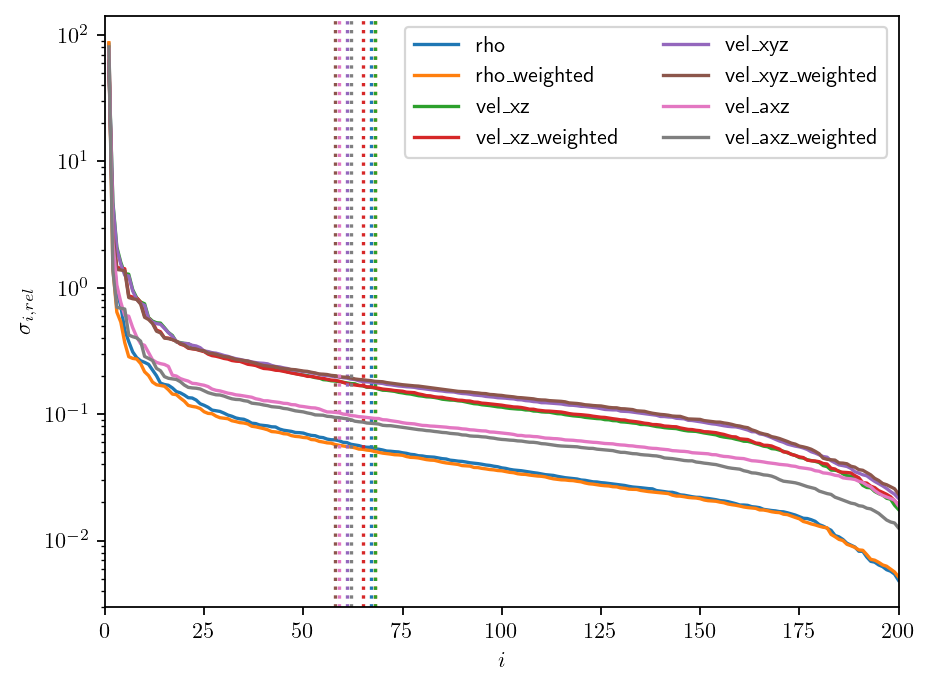

In [4]:
for i, key in enumerate(svd_results.keys()):
    sig_rel = svd_results[key]["sig_rel"]
    n_s = sig_rel.shape[0]
    plt.plot(range(1, n_s+1), sig_rel, c=f"C{i}", label=key)
    plt.axvline(svd_results[key]["opt_rank"], ls=":", c=f"C{i}")
    
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$")
plt.legend(ncol=2)
plt.yscale("log")
plt.xlim(0, n_s)
plt.show()

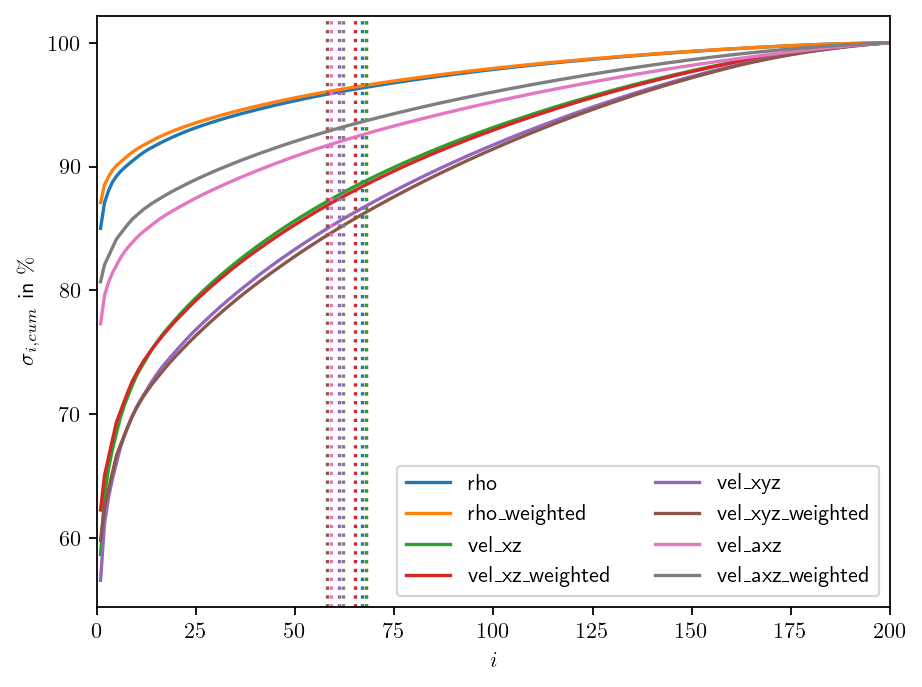

In [5]:
for i, key in enumerate(svd_results.keys()):
    sig_cum = svd_results[key]["sig_cum"]
    n_s = sig_cum.shape[0]
    plt.plot(range(1, n_s+1), sig_cum, c=f"C{i}", label=key)
    plt.axvline(svd_results[key]["opt_rank"], ls=":", c=f"C{i}")
    
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,cum}$ in $\%$")
plt.legend(ncol=2)
plt.xlim(0, n_s)
plt.show()

## Rank sensitivity

In [6]:
dmd_variants = ("DMD", "optDMD", "TDMD", "optTDMD", "UDMD", "optUDMD")
state_variants = ["rho", "vel_xz", "vel_xyz", "vel_axz"]
all_variants = [f"{i[1]}_{i[0]}" for i in product(state_variants, dmd_variants)]
results = {}
for var in all_variants:
    results[var] = pt.load(join(path, f"{var}.pt"))
ranks = pt.load(join(path, "ranks.pt"))

### Projection error

In [7]:
markers = ("+", ".", "x")
def plot_error(state, fields, title, ylim=None, projection=True, norm=True):
    err_key = "pro_err" if projection else "rec_err"
    keys = [f"{var}_{state}" for var in dmd_variants]
    if projection:
        keys = [key for key in keys if "opt" not in key]
        ylabel = r"$|| \mathbf{Y} - \mathbf{AX} ||_F$"
    else:
        ylabel = r"$|| \mathbf{M} - \mathbf{\Phi D}_\mathbf{b} \mathbf{T_\lambda} ||_F$"
    fig, axarr = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
    ms=3
    lw = 0.5
    for i, dmd_key in enumerate(keys):
        for j, name in enumerate(fields):
            # unweighted error
            field_key = f"{err_key}_uw_uw_norm_{j}" if norm else f"{err_key}_uw_uw_{j}"
            axarr[0].plot(ranks, results[dmd_key][field_key], c=f"C{i}", ls="-", marker=markers[j], markersize=ms, lw=lw, label=dmd_key.split("_")[0] + f", {name}, uw")
            field_key = f"{err_key}_uw_w_norm_{j}" if norm else f"{err_key}_uw_w_{j}"
            axarr[0].plot(ranks, results[dmd_key][field_key], c=f"C{i}", ls="--", marker=markers[j], markersize=ms, lw=lw, label=dmd_key.split("_")[0] + f", {name}, w")
            # weighted error
            field_key = f"{err_key}_w_uw_norm_{j}" if norm else f"{err_key}_w_uw_{j}"
            axarr[1].plot(ranks, results[dmd_key][field_key], c=f"C{i}", ls="-", marker=markers[j], markersize=ms, lw=lw, label=dmd_key.split("_")[0] + f", {name}, uw")
            field_key = f"{err_key}_w_w_norm_{j}" if norm else f"{err_key}_w_w_{j}"
            axarr[1].plot(ranks, results[dmd_key][field_key], c=f"C{i}", ls="--", marker=markers[j], markersize=ms, lw=lw, label=dmd_key.split("_")[0] + f", {name}, w")
    for ax in axarr.flatten():
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlim(0, ranks[-1] + 5)
        ax.set_ylabel(ylabel)
        ax.set_yscale("log")
    axarr[1].set_xlabel(r"$r$")
    axarr[0].set_title(title + ", unweighted error")
    axarr[1].set_title(title + ", weighted error")
    axarr[0].legend(bbox_to_anchor=[1.0, 1.0], fontsize=6)
    plt.show()

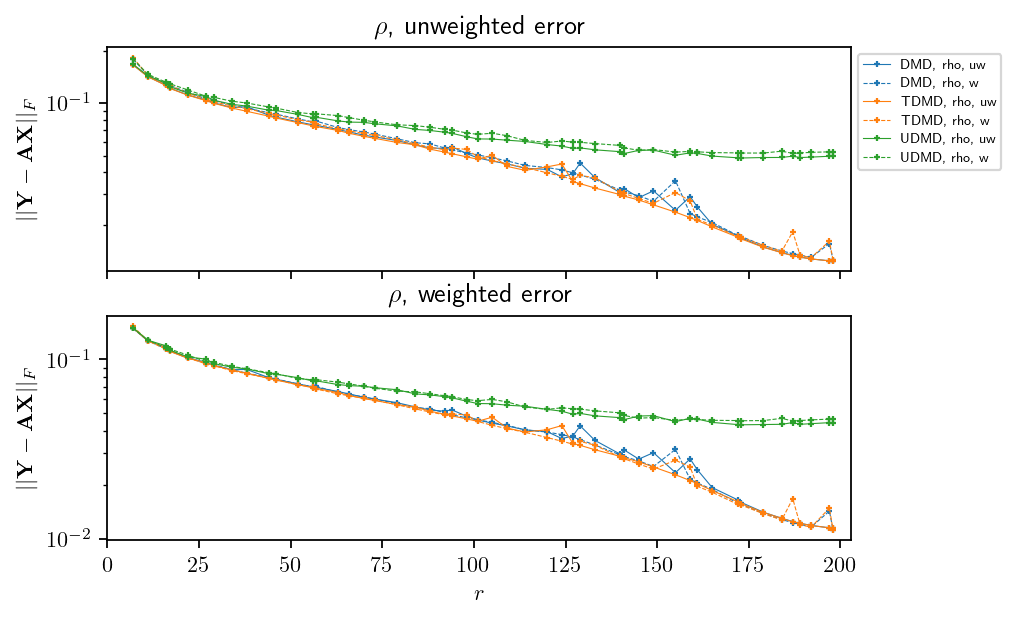

In [8]:
plot_error("rho", ["rho"], r"$\rho$")

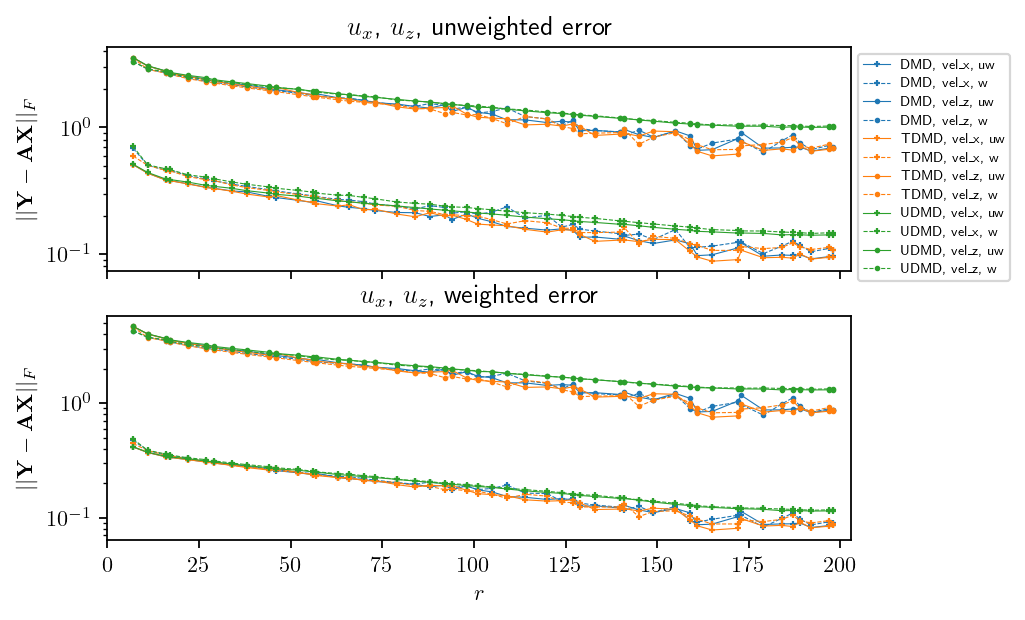

In [9]:
plot_error("vel_xz", ["vel_x", "vel_z"], r"$u_x$, $u_z$")

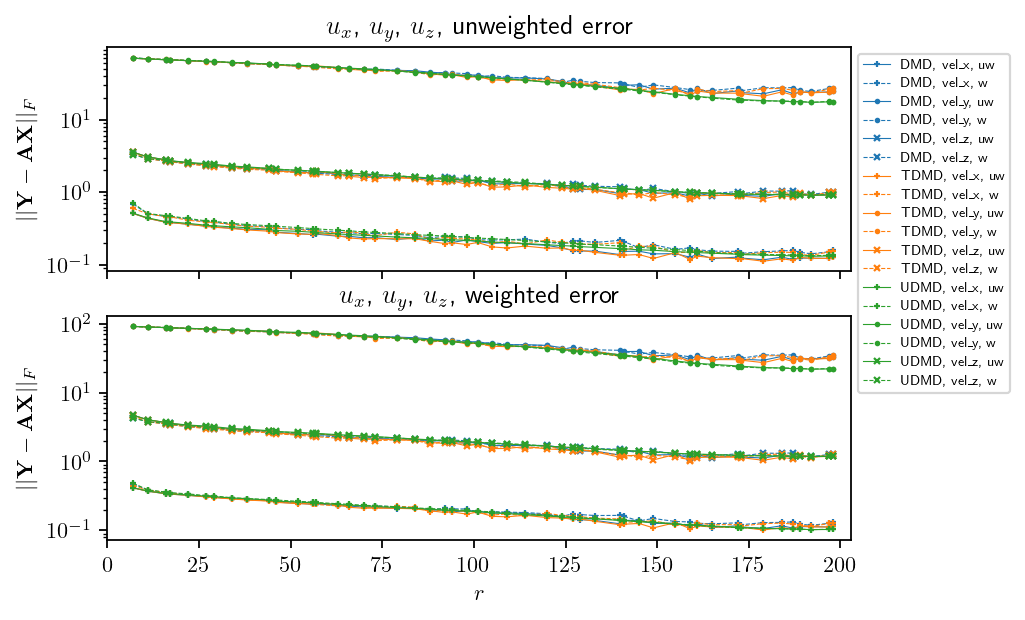

In [10]:
plot_error("vel_xyz", ["vel_x", "vel_y", "vel_z"], r"$u_x$, $u_y$, $u_z$")

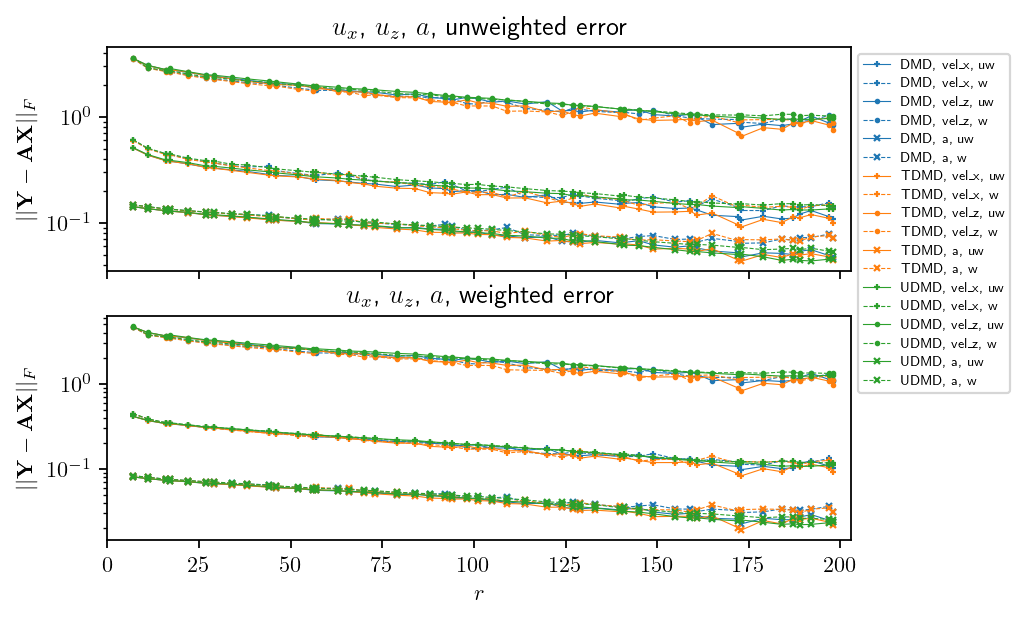

In [11]:
plot_error("vel_axz", ["vel_x", "vel_z", "a"], r"$u_x$, $u_z$, $a$")

### Reconstruction/prediction error

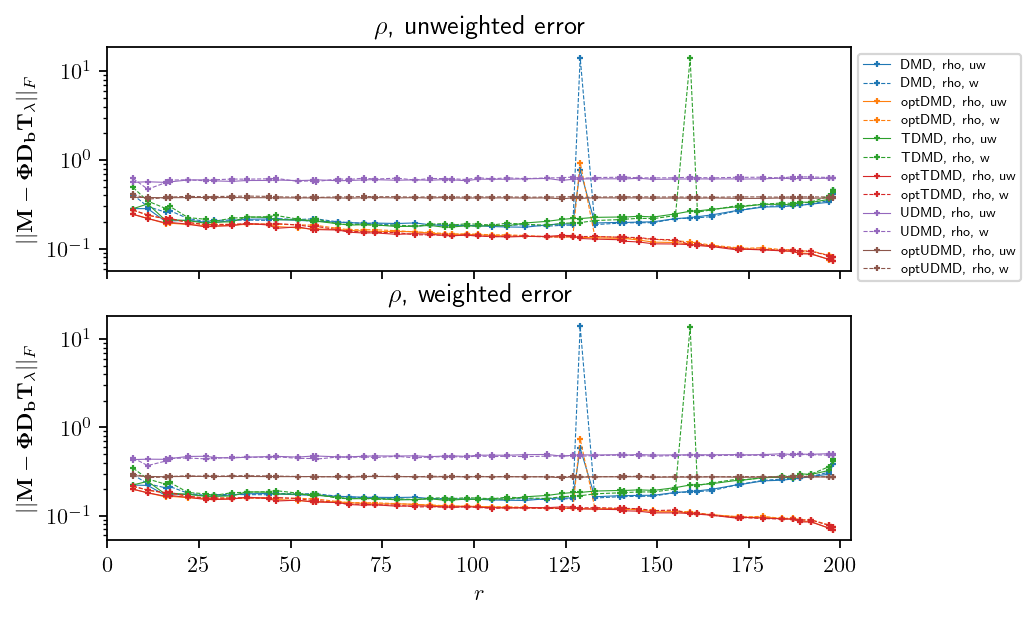

In [12]:
plot_error("rho", ["rho"], r"$\rho$", projection=False)

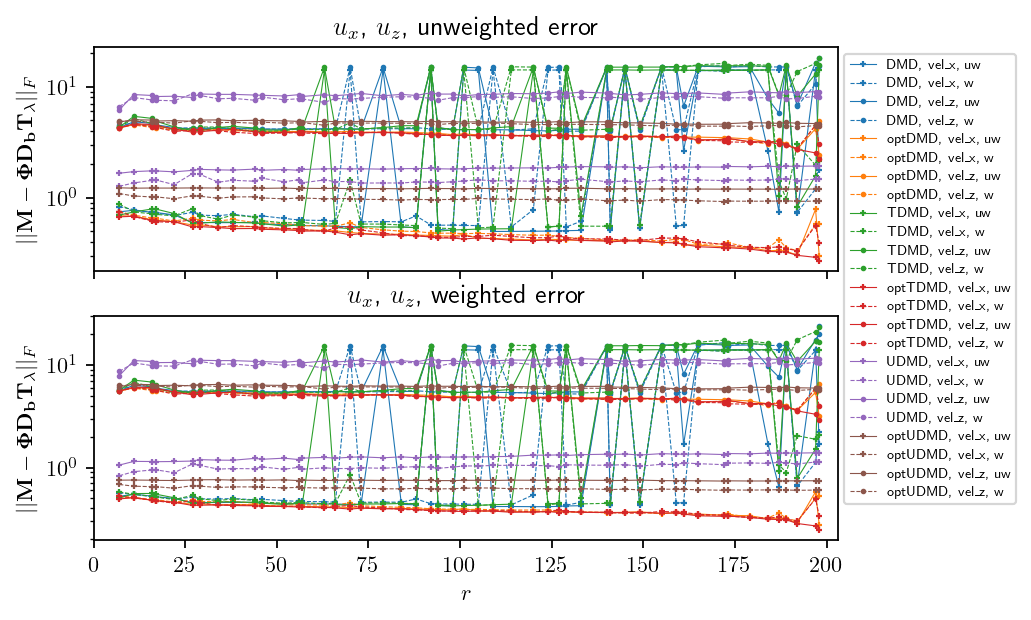

In [13]:
plot_error("vel_xz", ["vel_x", "vel_z"], r"$u_x$, $u_z$", projection=False)

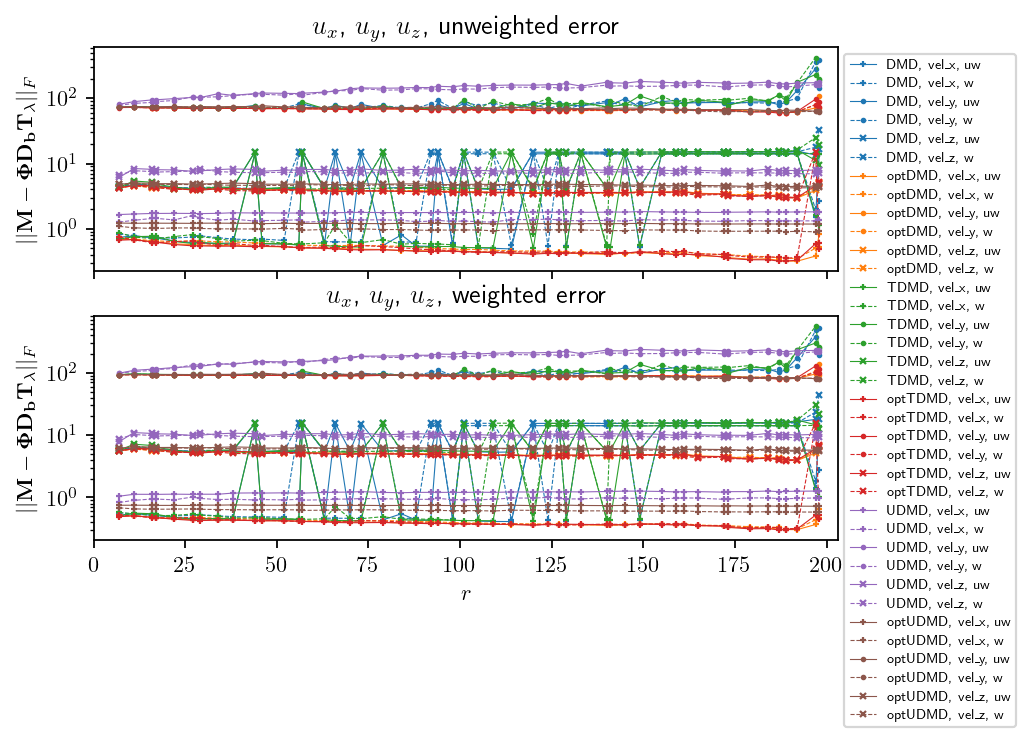

In [14]:
plot_error("vel_xyz", ["vel_x", "vel_y", "vel_z"], r"$u_x$, $u_y$, $u_z$", projection=False)

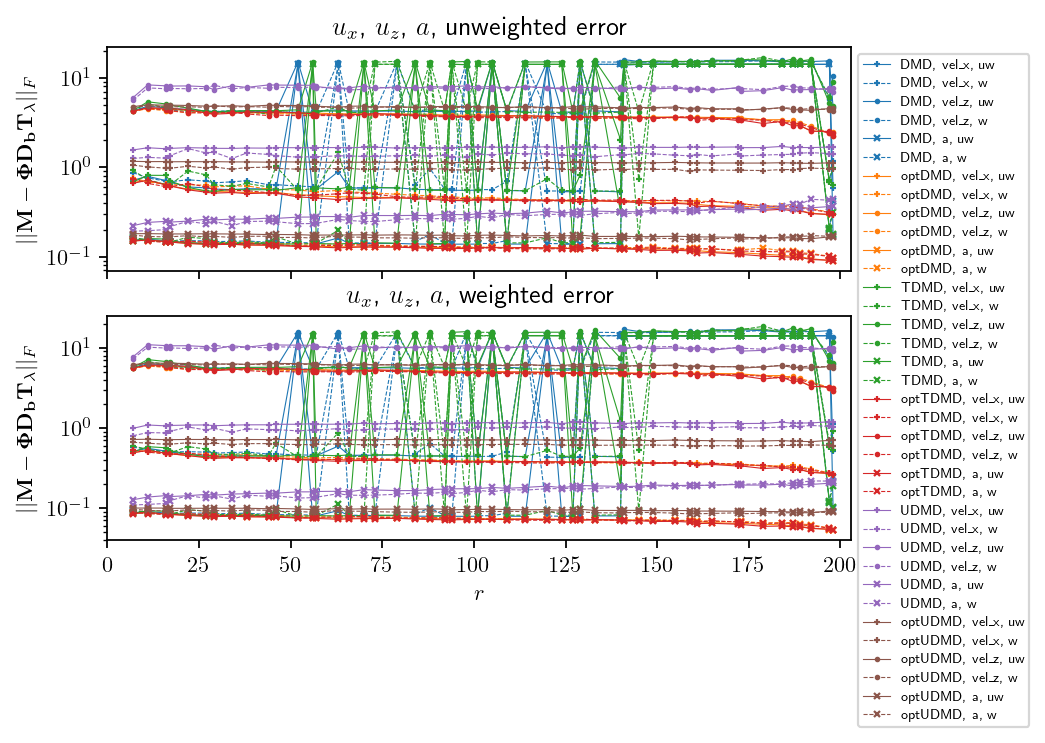

In [15]:
plot_error("vel_axz", ["vel_x", "vel_z", "a"], r"$u_x$, $u_z$, $a$", projection=False)

## Error plot with selected data for improved visualization

Q1: **What is the influence of the state vector on the projection error?**

To answer this questions, we compare the normalized projection error of $u_x$ and $u_z$ for the state vectors except for density.

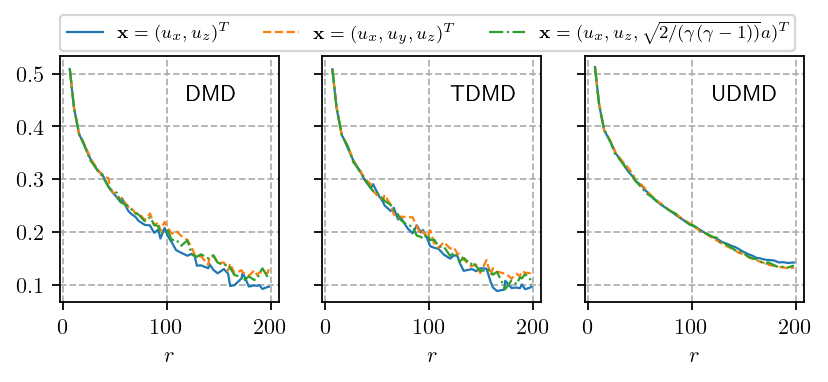

In [16]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

dmd_keys = ("DMD", "TDMD", "UDMD")
state_keys = ("vel_xz", "vel_xyz", "vel_axz")
state_labels = (r"$\mathbf{x} = (u_x, u_z)^T$", r"$\mathbf{x} = (u_x, u_y, u_z)^T$", r"$\mathbf{x} = (u_x, u_z, \sqrt{2/(\gamma (\gamma -1))} a)^T$")
state_ls = ("-", "--", "-.")
ux_ind, uz_ind = (0, 0, 0), (1, 2, 1)
for i, dmd_key in enumerate(dmd_keys):
    for j, state_key in enumerate(state_keys):
        axarr[i].plot(ranks, results[f"{dmd_key}_{state_key}"][f"pro_err_uw_uw_norm_{ux_ind[j]}"], ls=state_ls[j], lw=1, label=f"{state_labels[j]}")
    axarr[i].grid(True, ls="--")
    axarr[i].set_xlabel(r"$r$")
    axarr[i].text(120, 0.45, dmd_key)

plt.legend(fontsize=8, ncol=3, loc=0, bbox_to_anchor=(1.0, 1.2))
plt.show()

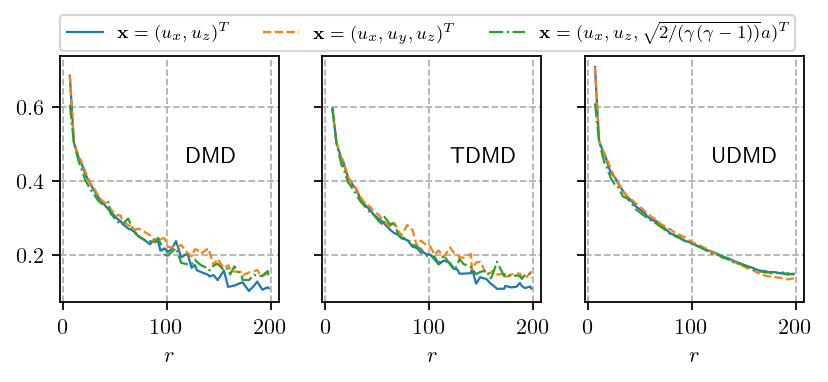

In [17]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

dmd_keys = ("DMD", "TDMD", "UDMD")
state_keys = ("vel_xz", "vel_xyz", "vel_axz")
state_labels = (r"$\mathbf{x} = (u_x, u_z)^T$", r"$\mathbf{x} = (u_x, u_y, u_z)^T$", r"$\mathbf{x} = (u_x, u_z, \sqrt{2/(\gamma (\gamma -1))} a)^T$")
state_ls = ("-", "--", "-.")
ux_ind, uz_ind = (0, 0, 0), (1, 2, 1)
for i, dmd_key in enumerate(dmd_keys):
    for j, state_key in enumerate(state_keys):
        axarr[i].plot(ranks, results[f"{dmd_key}_{state_key}"][f"pro_err_uw_w_norm_{ux_ind[j]}"], ls=state_ls[j], lw=1, label=f"{state_labels[j]}")
    axarr[i].grid(True, ls="--")
    axarr[i].set_xlabel(r"$r$")
    axarr[i].text(120, 0.45, dmd_key)

plt.legend(fontsize=8, ncol=3, loc=0, bbox_to_anchor=(1.0, 1.2))
plt.show()

 A1: **There is no significant difference between the state vectors in terms of projection error; this statement holds for the different DMD variants and also for optional weighting.**
 
 Q2: **What is the influence of weighting on the projection error?**
 
 To answer this question, we compare the projection errors with and without weighting for the state vector based on $u_x$ and $u_z$.

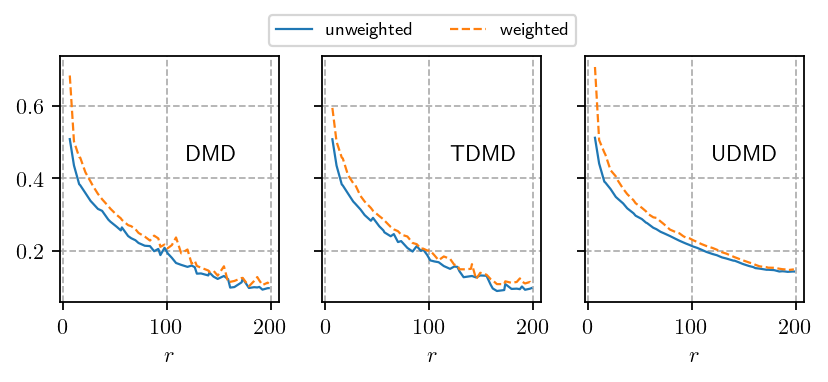

In [18]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

dmd_keys = ("DMD", "TDMD", "UDMD")
state = "vel_xz"
for i, dmd_key in enumerate(dmd_keys):
    axarr[i].plot(ranks, results[f"{dmd_key}_{state}"][f"pro_err_uw_uw_norm_0"], ls="-", lw=1, label=f"unweighted")
    axarr[i].plot(ranks, results[f"{dmd_key}_{state}"][f"pro_err_uw_w_norm_0"], ls="--", lw=1, label=f"weighted")
    axarr[i].grid(True, ls="--")
    axarr[i].set_xlabel(r"$r$")
    axarr[i].text(120, 0.45, dmd_key)

plt.legend(fontsize=8, ncol=2, loc=0, bbox_to_anchor=(0.0, 1.2))
plt.show()

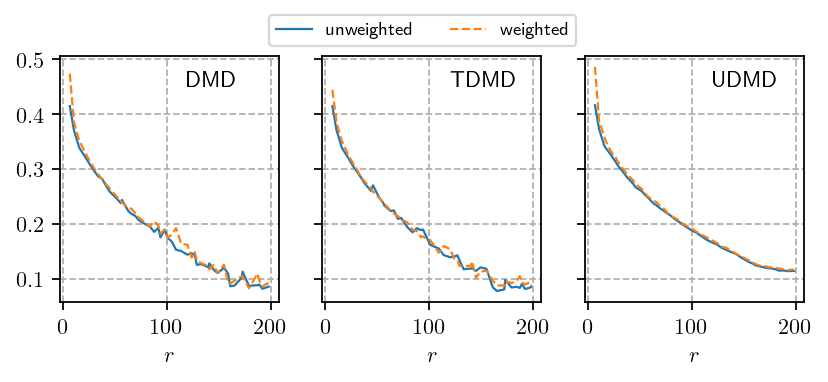

In [19]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

dmd_keys = ("DMD", "TDMD", "UDMD")
state = "vel_xz"
for i, dmd_key in enumerate(dmd_keys):
    axarr[i].plot(ranks, results[f"{dmd_key}_{state}"][f"pro_err_w_uw_norm_0"], ls="-", lw=1, label=f"unweighted")
    axarr[i].plot(ranks, results[f"{dmd_key}_{state}"][f"pro_err_w_w_norm_0"], ls="--", lw=1, label=f"weighted")
    axarr[i].grid(True, ls="--")
    axarr[i].set_xlabel(r"$r$")
    axarr[i].text(120, 0.45, dmd_key)

plt.legend(fontsize=8, ncol=2, loc=0, bbox_to_anchor=(0.0, 1.2))
plt.show()

A2: **There is no significant influence of area-weighting on the projection error; this statement holds for different DMD variants and state vectors.**

Q3: **Is the optimal version of each DMD variant more accurate?**

To answer this question, we compare the prediction error for the state vector based on $u_x$ and $u_z$.

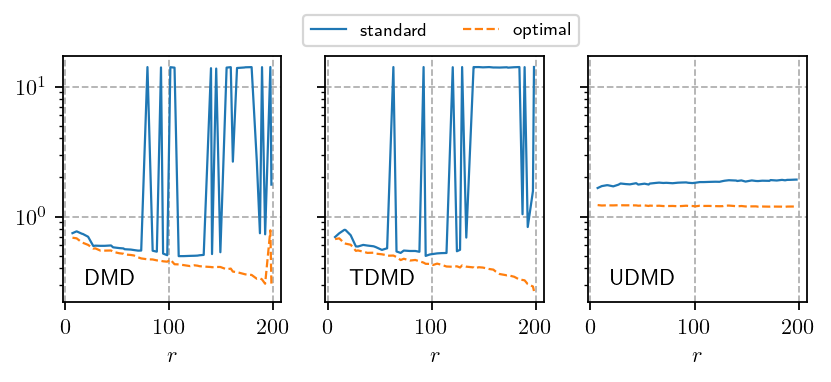

In [20]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

dmd_keys = ("DMD", "TDMD", "UDMD")
state = "vel_xz"
for i, dmd_key in enumerate(dmd_keys):
    axarr[i].plot(ranks, results[f"{dmd_key}_{state}"][f"rec_err_uw_uw_norm_0"], ls="-", lw=1, label=f"standard")
    axarr[i].plot(ranks, results[f"opt{dmd_key}_{state}"][f"rec_err_uw_uw_norm_0"], ls="--", lw=1, label=f"optimal")
    axarr[i].grid(True, ls="--")
    axarr[i].set_xlabel(r"$r$")
    axarr[i].text(20, 0.3, dmd_key)
    axarr[i].set_yscale("log")

plt.legend(fontsize=8, ncol=2, loc=0, bbox_to_anchor=(0.0, 1.2))
plt.show()

A3: **The optimal coefficients lead to a significant reduction of the prediction error; moreover, the predictions are more stable with respect to rank truncation; these observations hold regardless of the employed state vector, weighting, and DMD variant.**

### Eigenvalues

In [21]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Code copied from:
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                                  facecolor=facecolor, zorder=8, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = mpl.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [27]:
TOL = 1.0

def extract_top_eigval(key, weighted):
    er_amp, ei_amp, er_int, ei_int = [], [], [], []
    suffix = "_w" if weighted else ""
    e = results[key][f"eigvals{suffix}"]
    f = results[key][f"frequency{suffix}"]
    si = results[key][f"top_100_int{suffix}"]
    sa = results[key][f"top_100_amp{suffix}"]
    for i in range(ranks.shape[0]):
        top_a = pt.tensor([j for j in sa[i] if f[i][j] > TOL], dtype=pt.int64)
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        er_amp.append(e[i][top_a[0]].real.item())
        ei_amp.append(e[i][top_a[0]].imag.item())
        er_int.append(e[i][top_i[0]].real.item())
        ei_int.append(e[i][top_i[0]].imag.item())
    return er_amp, ei_amp, er_int, ei_int

def plot_eigvals(state, weighted=True):
    fig, axarr = plt.subplots(4, 3, figsize=(6, 8), sharex=True, sharey=True)
    t = pt.linspace(0, 2 * np.pi, 100)
    for ax in axarr.flatten():
        ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
        ax.set_aspect("equal")
        ax.set_xlim(0.95, 1.05)
        ax.set_ylim(0.0, 0.1)
    for ax in axarr[-1, :]:
        ax.set_xlabel(r"$\Re(\lambda)$")
    for ax in axarr[:, 0]:
        ax.set_ylabel(r"$\Im(\lambda)$")
    
    for i, key in enumerate(("DMD", "TDMD", "UDMD")):
        # standard
        er_amp, ei_amp, er_int, ei_int = extract_top_eigval(f"{key}_{state}", weighted)
        axarr[0, i].scatter(er_amp, ei_amp, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        axarr[1, i].scatter(er_int, ei_int, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        confidence_ellipse(np.array(er_amp), np.array(ei_amp), axarr[0, i], n_std=2, edgecolor="C3")
        confidence_ellipse(np.array(er_int), np.array(ei_int), axarr[1, i], n_std=2, edgecolor="C3")
        axarr[0, i].scatter([sum(er_amp)/len(er_amp)], [sum(ei_amp)/len(ei_amp)], c=f"C3", s=30, marker="*", zorder=8)
        axarr[1, i].scatter([sum(er_int)/len(er_int)], [sum(ei_int)/len(ei_int)], c=f"C3", s=30, marker="*", zorder=8)
        axarr[0, i].set_title(f"{key}, amp.")
        axarr[1, i].set_title(f"{key}, int.")
        #optimal
        er_amp, ei_amp, er_int, ei_int = extract_top_eigval(f"opt{key}_{state}", weighted)
        axarr[2, i].scatter(er_amp, ei_amp, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        axarr[3, i].scatter(er_int, ei_int, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        confidence_ellipse(np.array(er_amp), np.array(ei_amp), axarr[2, i], n_std=2, edgecolor="C3")
        confidence_ellipse(np.array(er_int), np.array(ei_int), axarr[3, i], n_std=2, edgecolor="C3")
        axarr[2, i].scatter([sum(er_amp)/len(er_amp)], [sum(ei_amp)/len(ei_amp)], c=f"C3", s=30, marker="*", edgecolor="C3", zorder=9)
        axarr[3, i].scatter([sum(er_int)/len(er_int)], [sum(ei_int)/len(ei_int)], c=f"C3", s=30, marker="*", edgecolor="C3", zorder=9)
        axarr[2, i].set_title(f"opt. {key}, amp.")
        axarr[3, i].set_title(f"opt. {key}, int.")
    line = plt.Line2D([0.02, 0.9], [0.51, 0.51], ls=":", transform=fig.transFigure, color="black", alpha=0.5)
    fig.add_artist(line)
    plt.subplots_adjust(hspace=0.3)
    suffix = "_weighted" if weighted else ""
    plt.savefig(join(path, f"{state}_eigvals{weighted}.pdf"), bbox_inches="tight")
    plt.show()

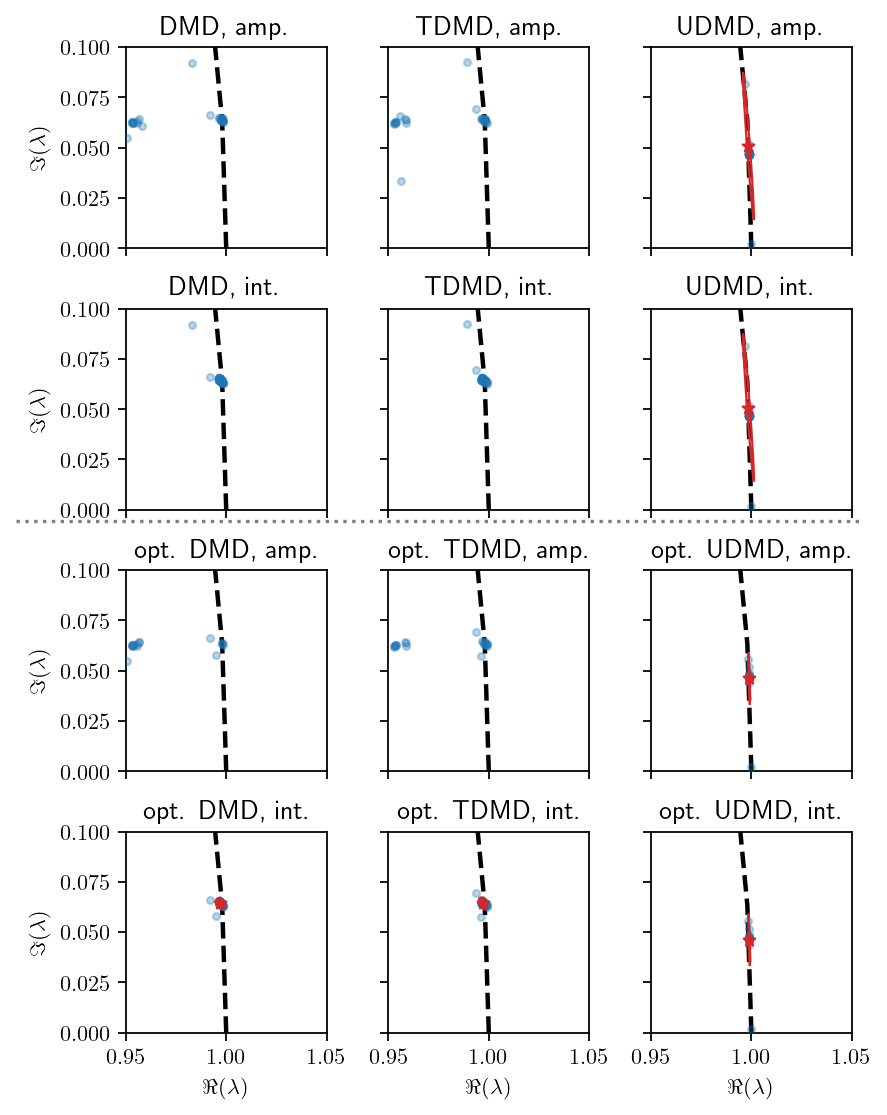

In [28]:
plot_eigvals("rho")

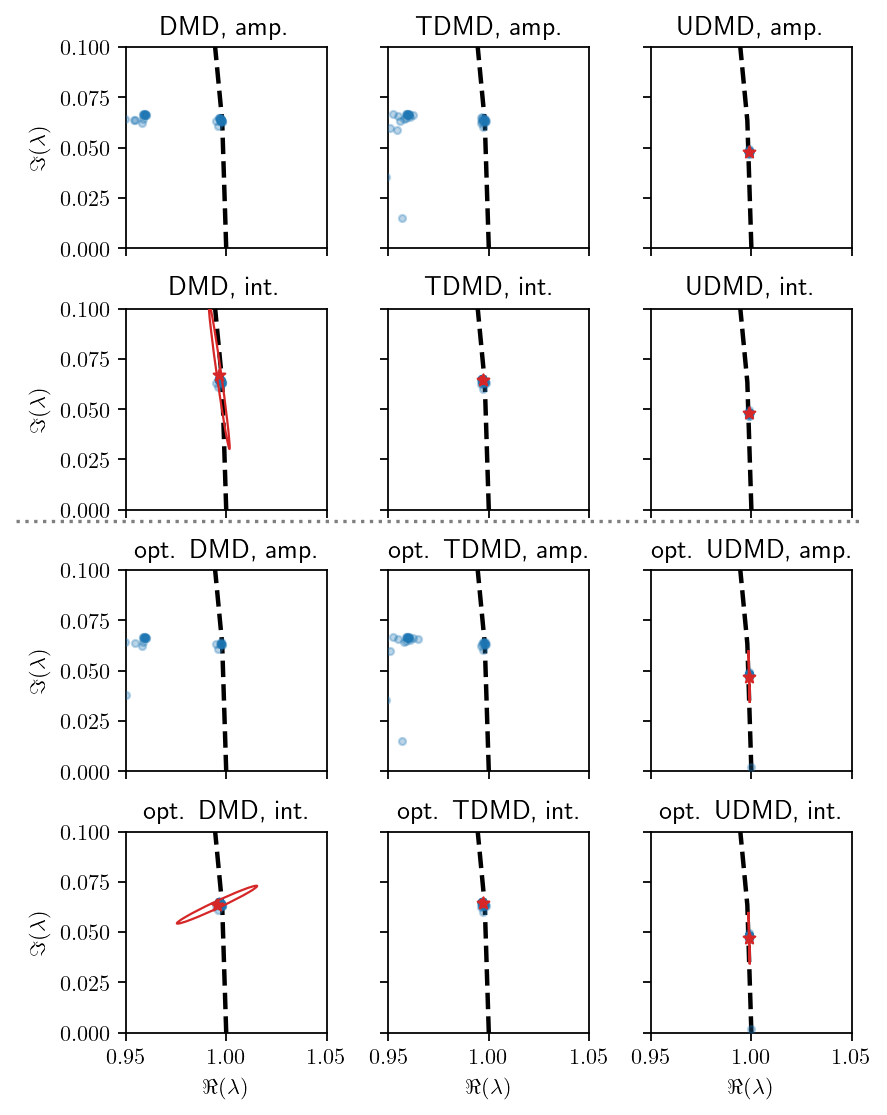

In [29]:
plot_eigvals("rho", False)

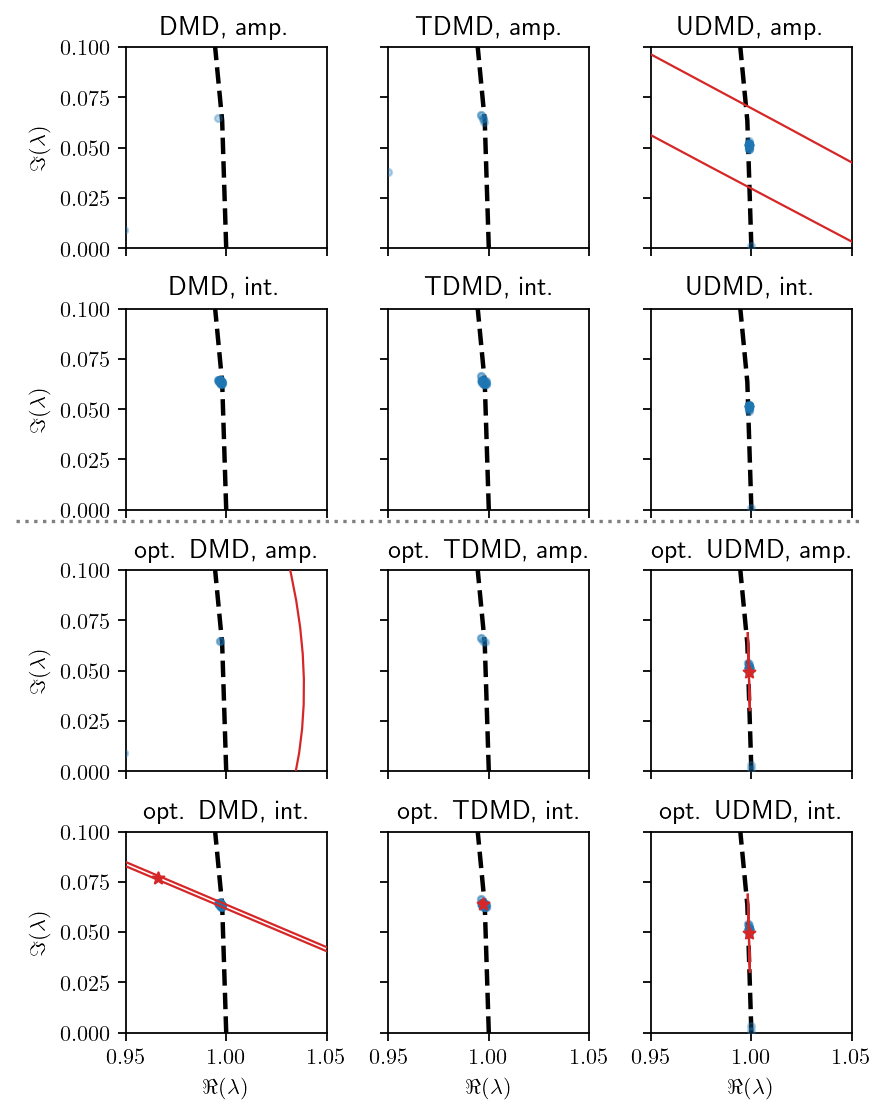

In [30]:
plot_eigvals("vel_xz")

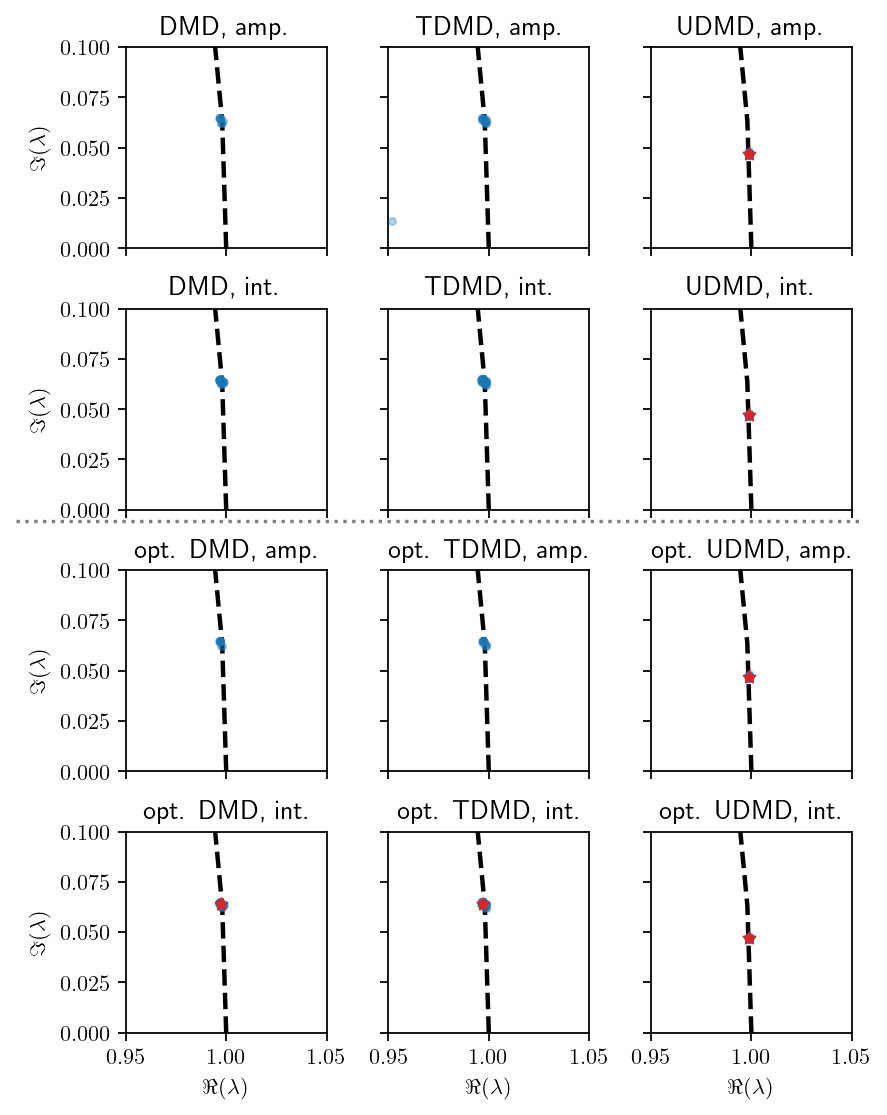

In [31]:
plot_eigvals("vel_xz", False)

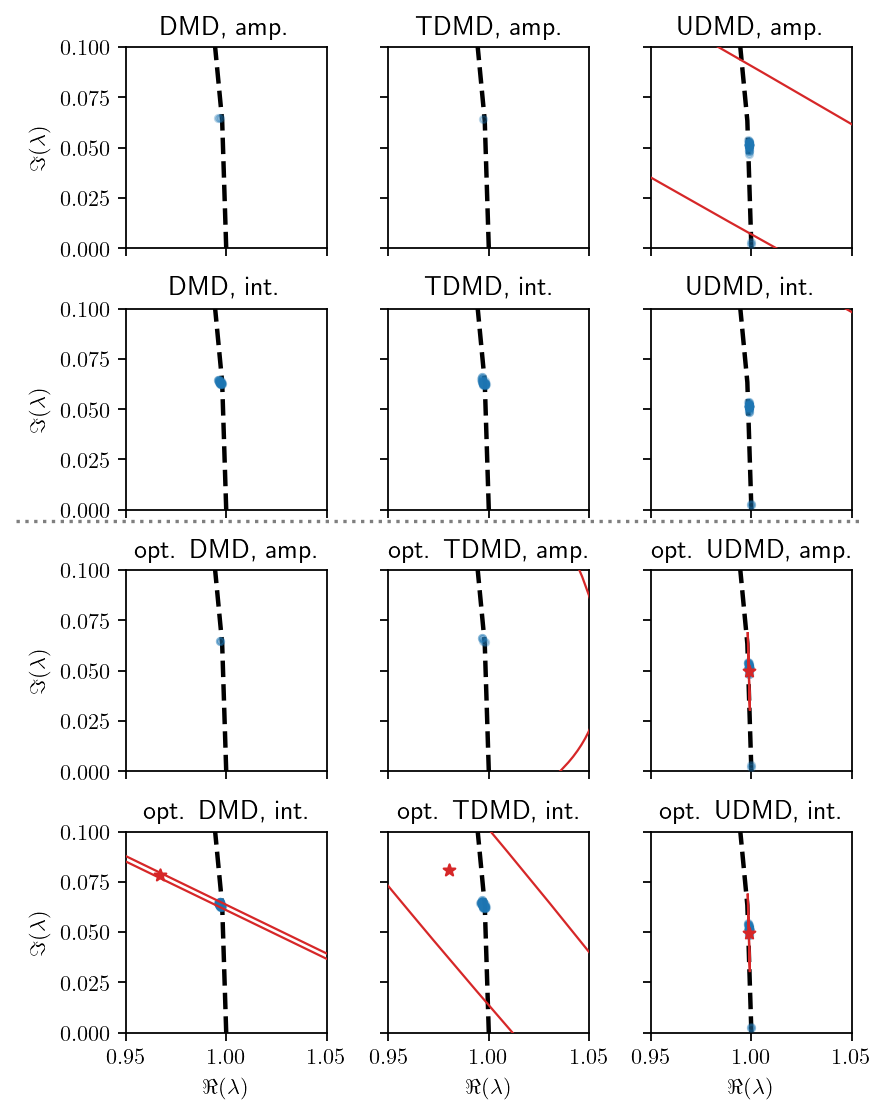

In [32]:
plot_eigvals("vel_xyz")

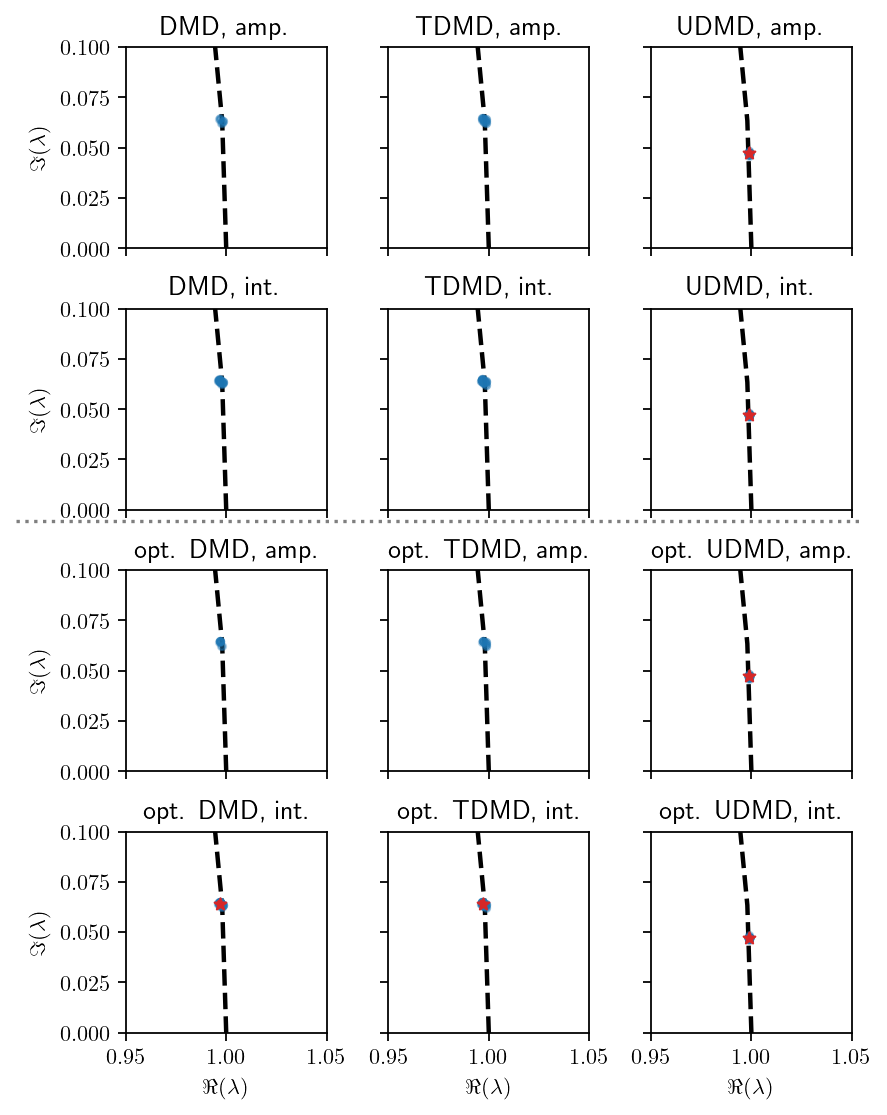

In [33]:
plot_eigvals("vel_xyz", False)

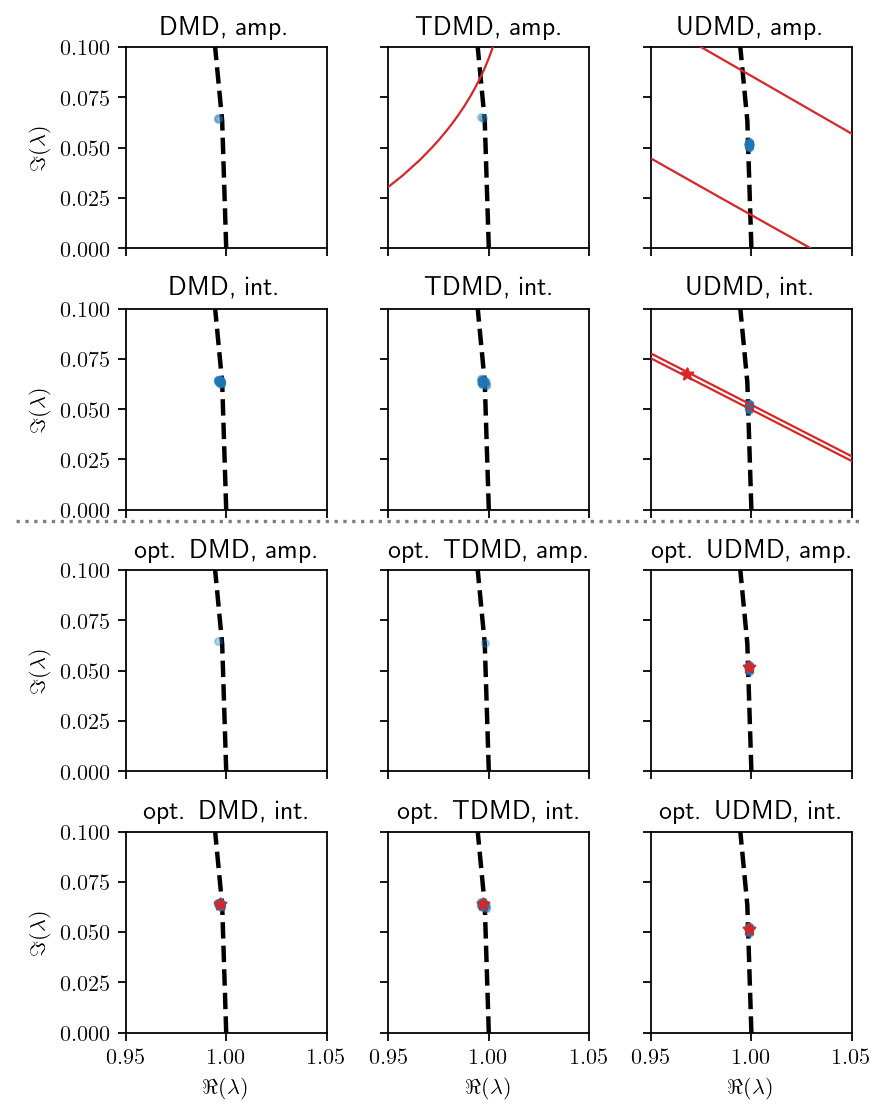

In [34]:
plot_eigvals("vel_axz")

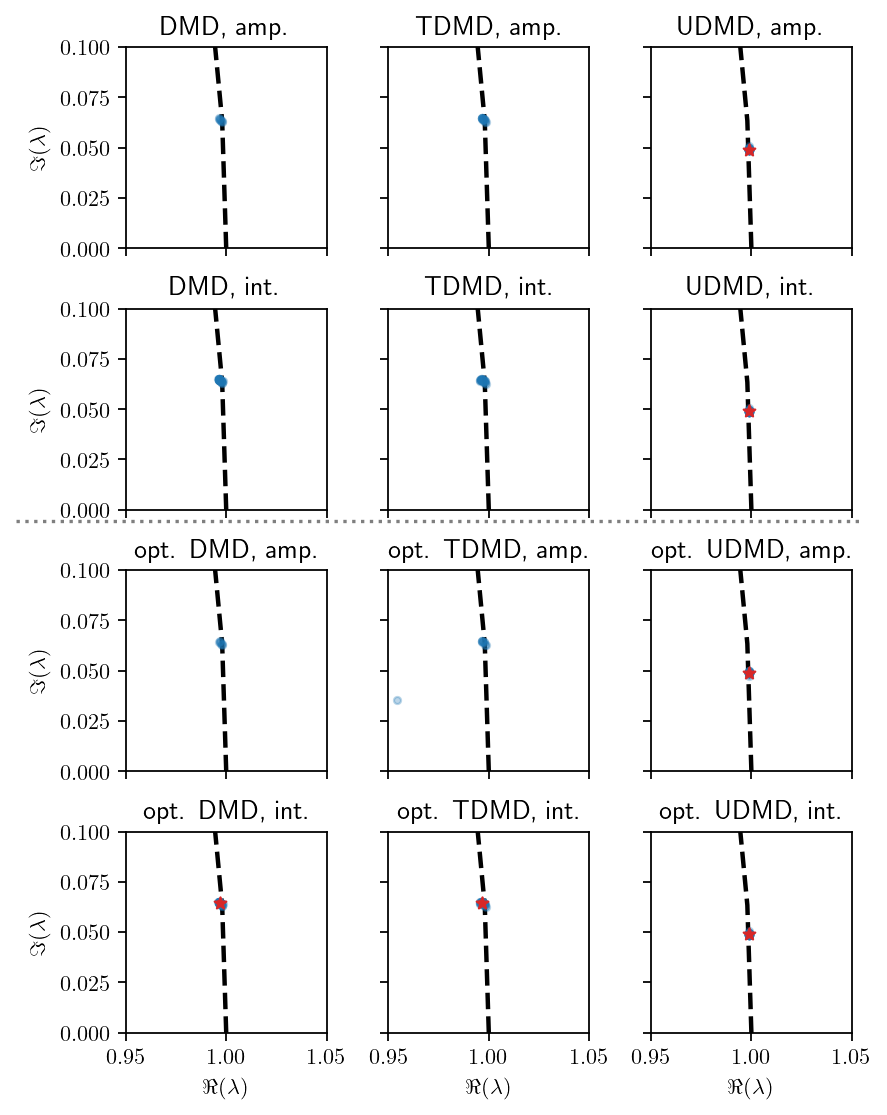

In [35]:
plot_eigvals("vel_axz", False)

### Buffet frequency

In [38]:
CHORD = 0.15
U_INF = 238.59

In [41]:
TOL = 1.0

def extract_top_freq(key, weighted):
    f_a, f_i = [], []
    suffix = "_w" if weighted else ""
    e = results[key][f"eigvals{suffix}"]
    f = results[key][f"frequency{suffix}"]
    si = results[key][f"top_100_int{suffix}"]
    sa = results[key][f"top_100_amp{suffix}"]
    for i in range(ranks.shape[0]):
        top_a = pt.tensor([j for j in sa[i] if f[i][j] > TOL], dtype=pt.int64)
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        f_a.append(f[i][top_a[0]].item())
        f_i.append(f[i][top_i[0]].item())
    return f_a, f_i

def plot_frequency(state, weighted=True):
    fig, axarr = plt.subplots(3, 1, figsize=(6, 5), sharex=True, sharey=True)
    fb = normalize_frequency(118.5, CHORD, U_INF)
    fbmax = fb * 1.5
    fbmin = fb * 0.5
    for i, key in enumerate(("DMD", "TDMD", "UDMD")):
        f_a, f_i =  extract_top_freq(f"{key}_{state}", weighted)
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_a), CHORD, U_INF), fbmin, fbmax), lw=1, s=20, marker="o", label=r"amp.")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_i), CHORD, U_INF), fbmin, fbmax), lw=1, s=20, marker="*", label=r"int.")
        f_a, f_i =  extract_top_freq(f"opt{key}_{state}", weighted)
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_a), CHORD, U_INF), fbmin, fbmax), lw=1, s=20, marker="x", label=r"opt., amp.")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_i), CHORD, U_INF), fbmin, fbmax), lw=1, s=20, marker="+", label=r"opt., int.")
        

        axarr[i].axhline(fb, ls="--", c="k", label=r"$\tilde{f}_b$")
        axarr[i].axvline(svd_results[state]["opt_rank"], ls=":", c="k")
        axarr[i].text(svd_results[state]["opt_rank"]-6, 0.5*(fb+fbmax), r"$r_{\mathrm{opt}}$", rotation=90, va="center")
        if i == 0:
            axarr[i].legend(ncol=5, loc="upper center", fontsize=10, bbox_to_anchor=(0.5, 1.35))
        axarr[i].text(201, fb, key, rotation=90, va="center")
        axarr[i].set_ylabel(r"$\tilde{f}_{\mathrm{dom}}$")
        axarr[i].set_ylim(fbmin, fbmax)
    axarr[-1].set_xlabel(r"$r$")
    axarr[-1].set_xlim(ranks[0], ranks[-1])
    suffix = "_weighted" if weighted else ""
    plt.savefig(join(path, f"{state}_freq{suffix}.pdf"), bbox_inches="tight")
    plt.show()

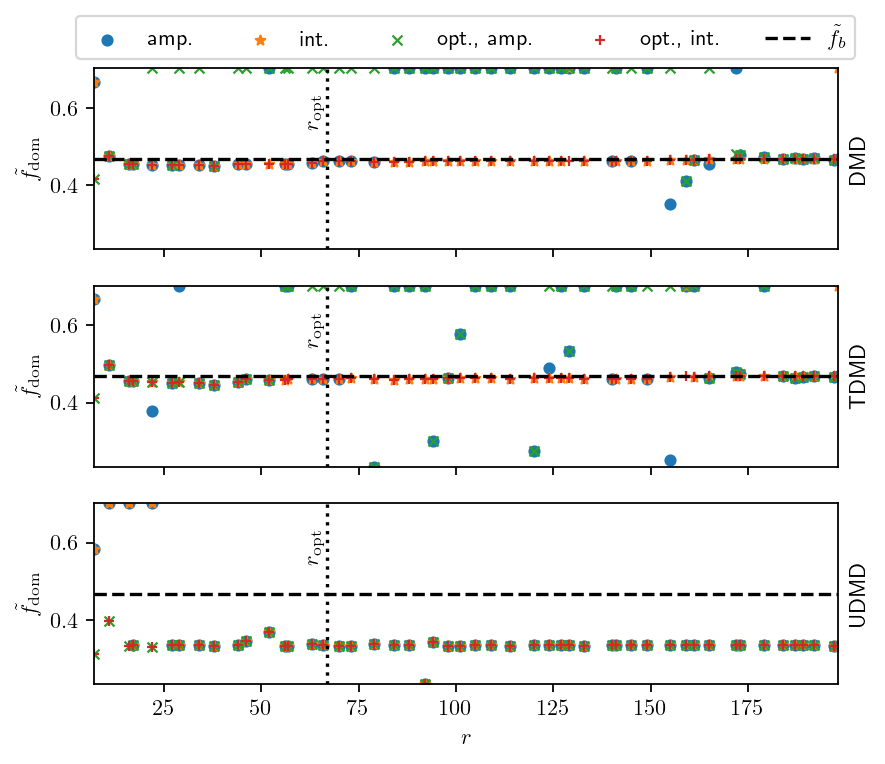

In [42]:
plot_frequency("rho")

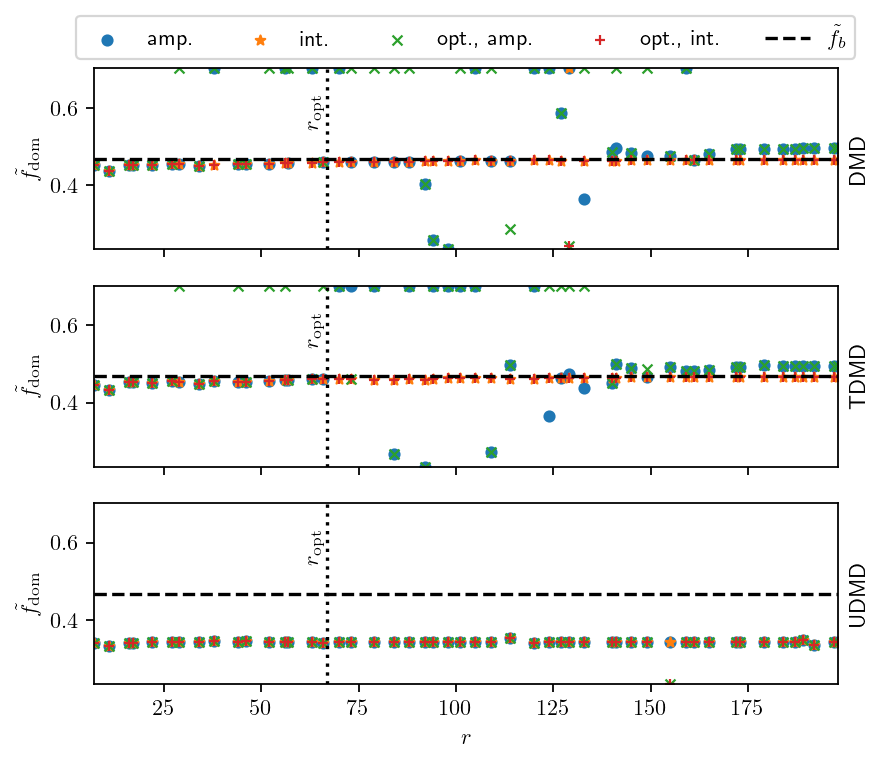

In [43]:
plot_frequency("rho", False)

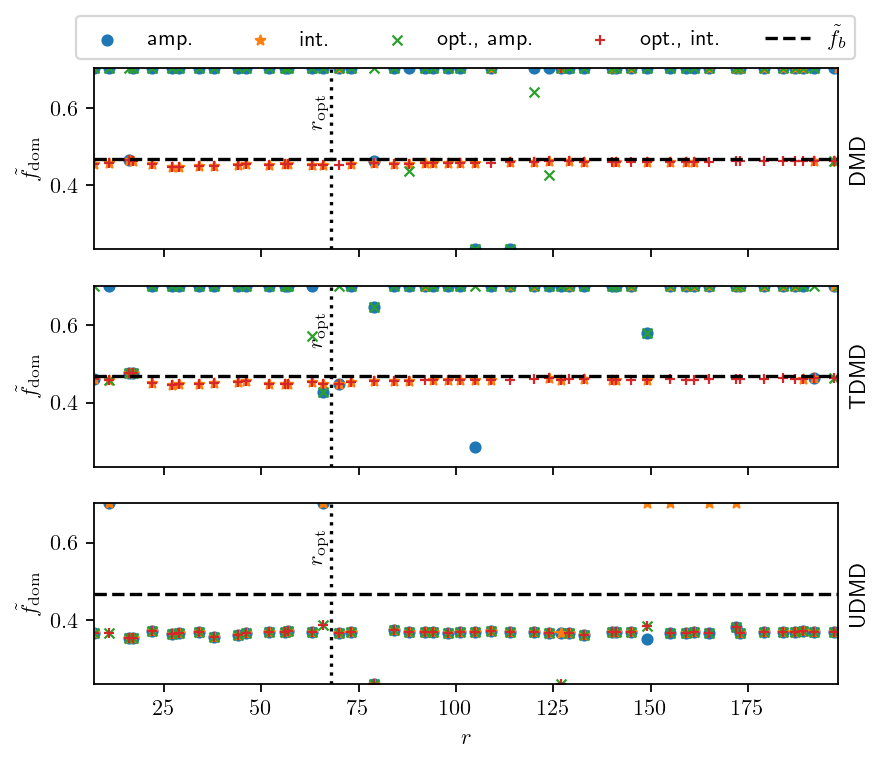

In [44]:
plot_frequency("vel_xz")

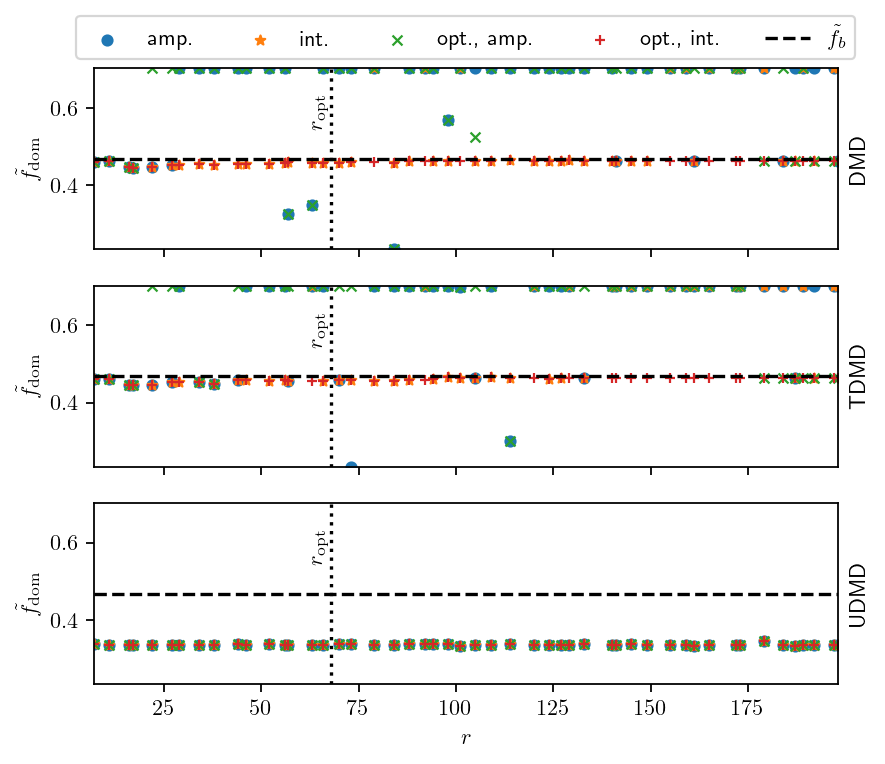

In [45]:
plot_frequency("vel_xz", False)

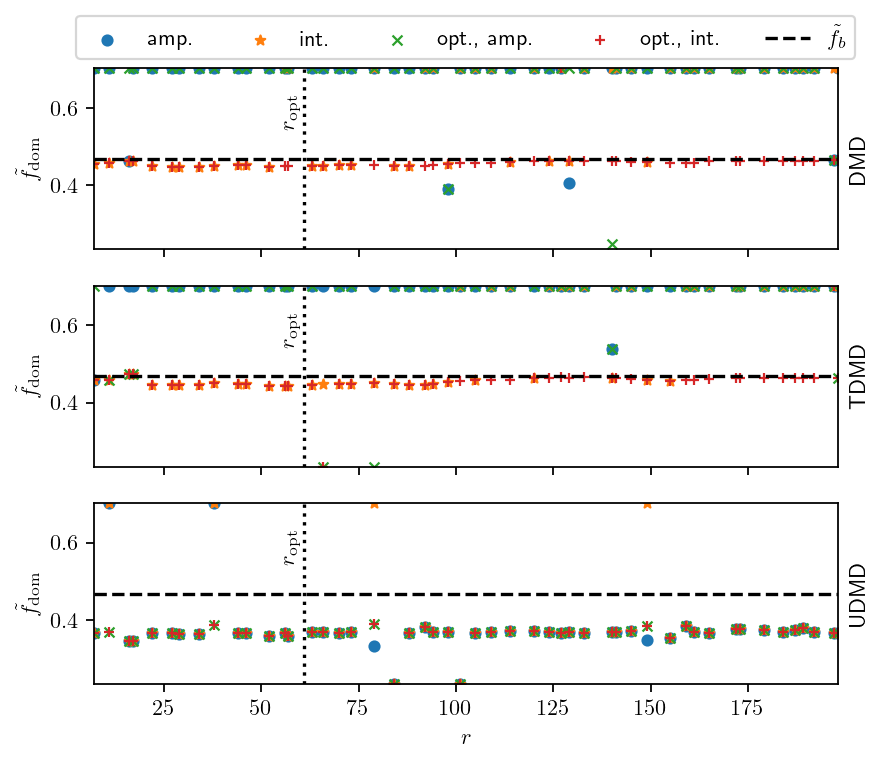

In [46]:
plot_frequency("vel_xyz")

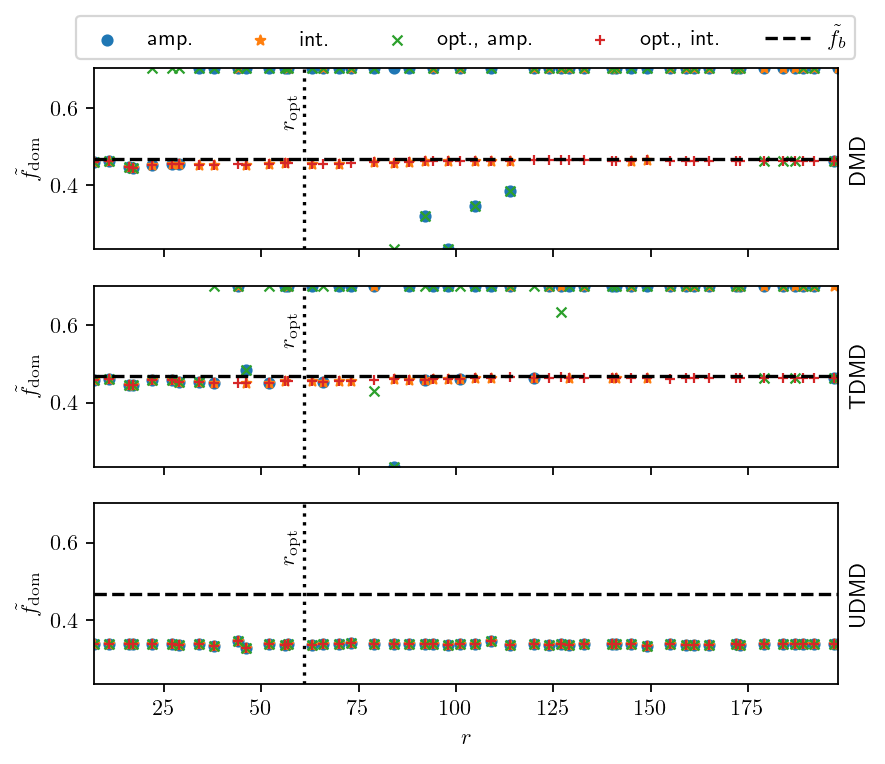

In [47]:
plot_frequency("vel_xyz", False)

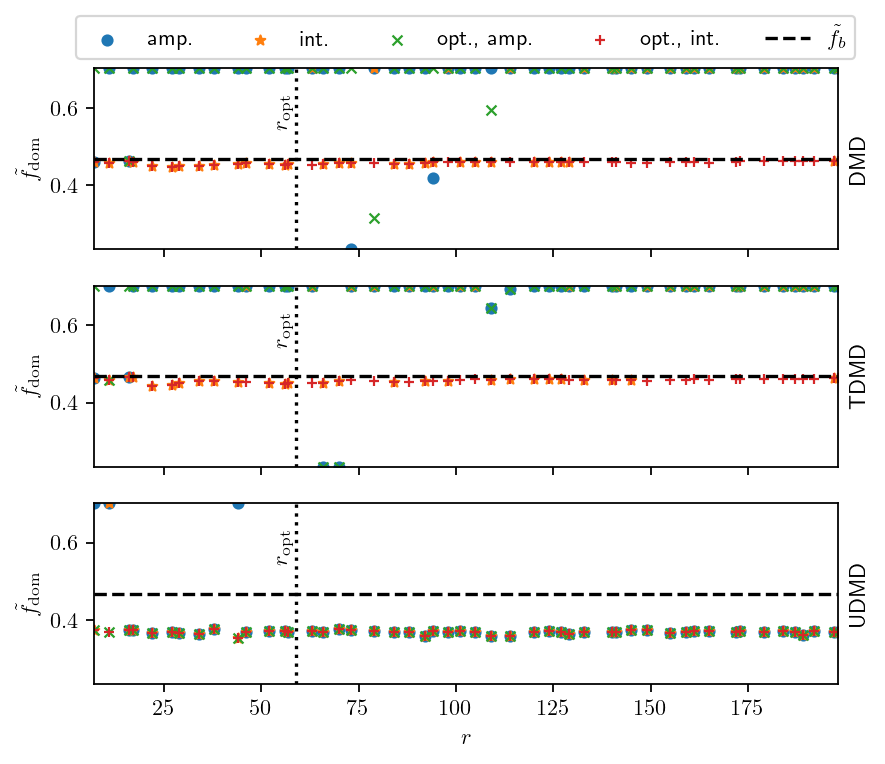

In [49]:
plot_frequency("vel_axz")

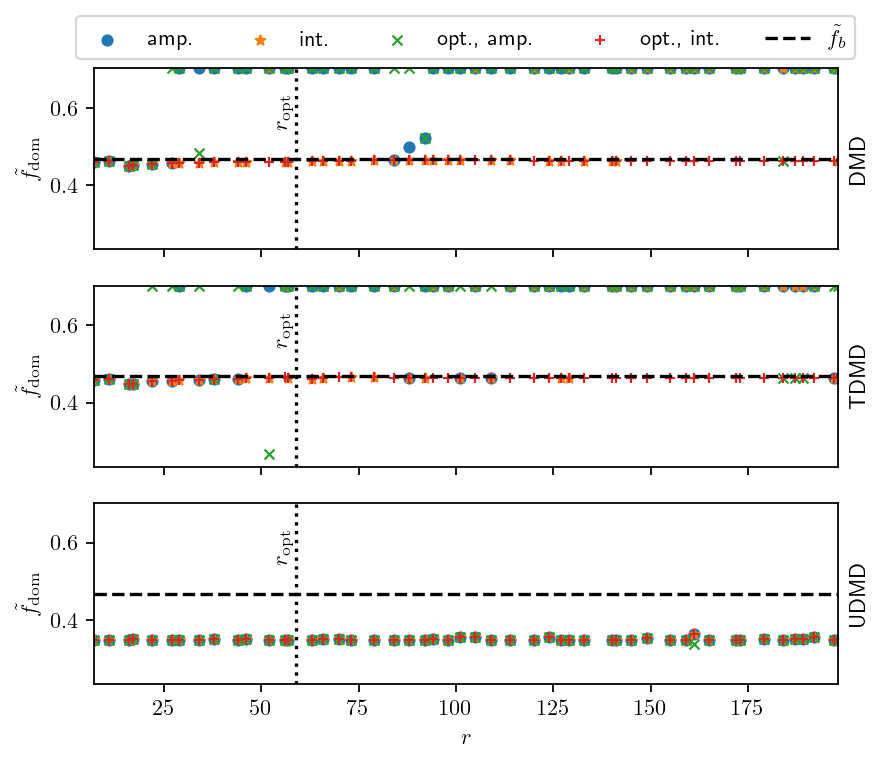

In [50]:
plot_frequency("vel_axz", False)

## Rank sensitivity of full DMD spectra

In [62]:
TOL = 1.0
def plot_spectra_over_rank(key, weighted, rank, k, f_bins=50, title="", scale=10.0):
    suffix = "_w" if weighted else ""
    freq, integral = results[key][f"frequency{suffix}"], results[key][f"importance{suffix}"]
    f, imp, r = [], [], []
    top_f, top_imp, top_r = [], [], []
    for fi, ii, ri in zip(freq, integral, rank):
        f.append(fi[fi > TOL])
        imp.append(ii[fi > TOL])
        r.append(pt.ones(f[-1].shape[0]) * ri)
        top_k = imp[-1].argsort(descending=True)[:k]
        top_f.append(f[-1][top_k])
        top_imp.append(imp[-1][top_k])
        top_r.append(pt.ones(top_f[-1].shape[0]) * ri)
    f, imp, r, top_f, top_imp, top_r = [pt.cat(i, dim=0) for i in (f, imp, r, top_f, top_imp, top_r)]
    imp /= imp.max()
    top_imp /= top_imp.max()
    # creating axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.8
    spacing = 0.04
    box_scatter = [left, bottom, width, height]
    box_hist = [left + width + spacing, bottom, 0.2, height]
    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_axes(box_scatter)
    ax2 = fig.add_axes(box_hist, sharey=ax1)
    # scatter plot
    ax1.scatter(r, normalize_frequency(f, CHORD, U_INF), c="C0", marker="o", s=imp*scale)
    ax1.scatter(top_r, normalize_frequency(top_f, CHORD, U_INF), c="C3", marker="o", s=top_imp*scale)
    ax1.set_xlim(r.min()-1, r.max()+1)
    ax1.set_ylim(0, 20)
    ax1.set_title(title)
    ax1.set_xlabel(r"$r$")
    ax1.set_ylabel(r"$\tilde{f}$")
    # histogram
    ax2.hist(normalize_frequency(f, CHORD, U_INF).numpy(), bins=f_bins, weights=imp.sqrt().numpy(), density=True, orientation='horizontal')
    ax2.tick_params(axis="y", labelleft=False)
    ax2.set_title(r"$I_i$-weighted PD")

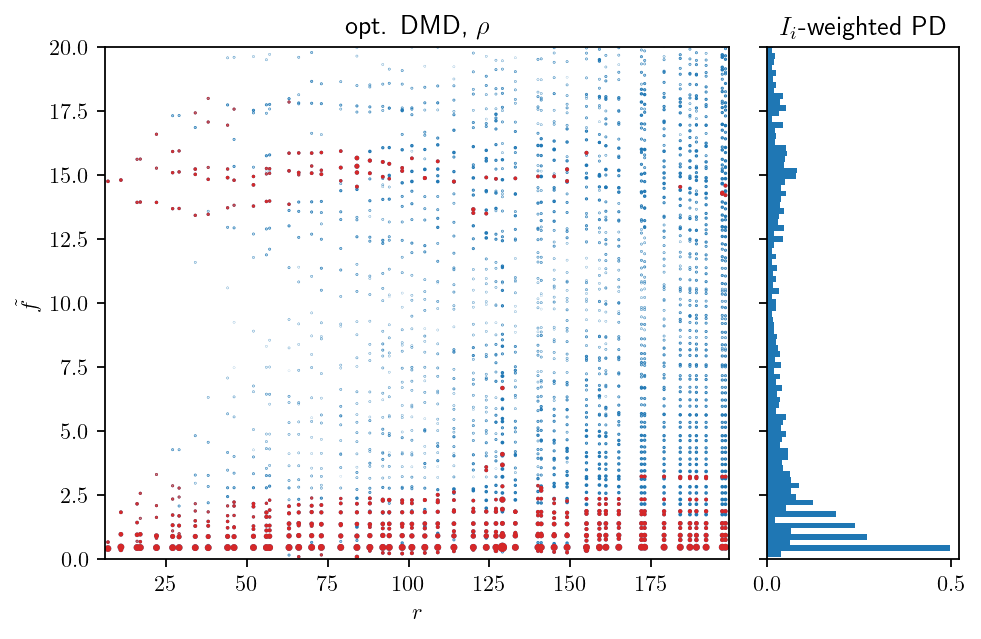

In [76]:
key = "optDMD_rho"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. DMD, $\rho$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

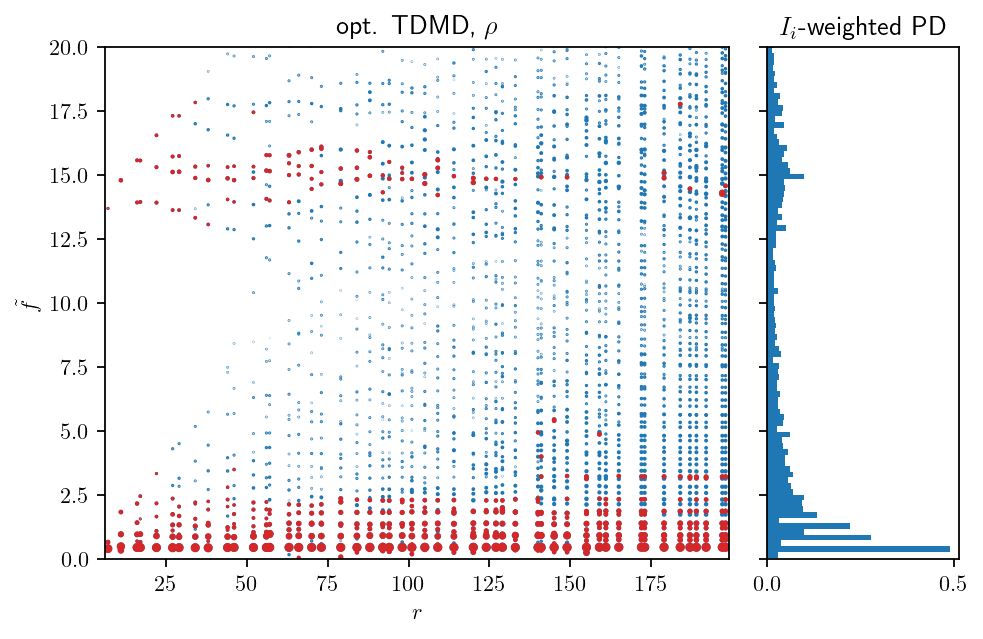

In [75]:
key = "optTDMD_rho"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. TDMD, $\rho$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

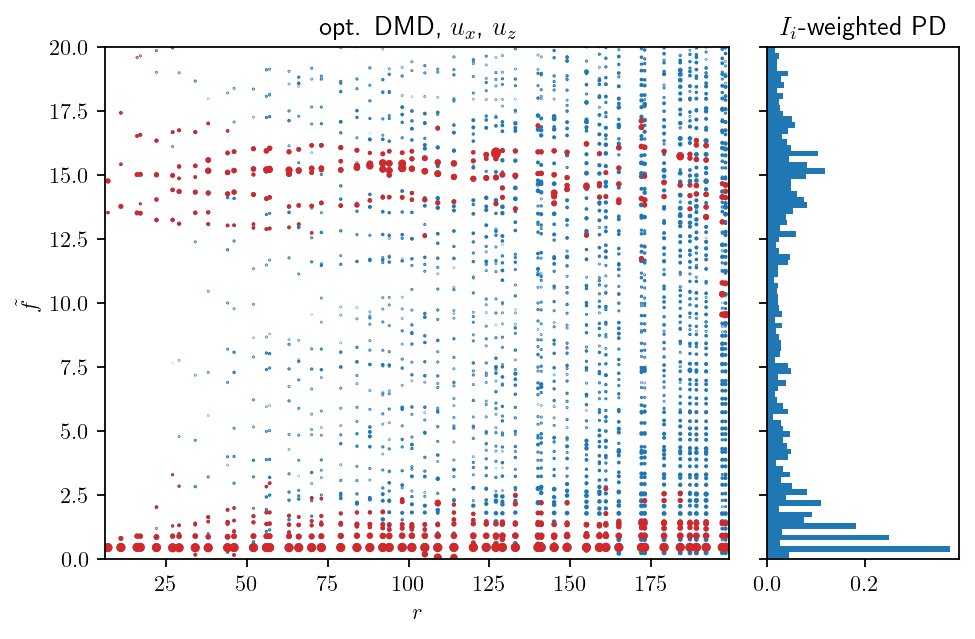

In [74]:
key = "optDMD_vel_xz"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. DMD, $u_x$, $u_z$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

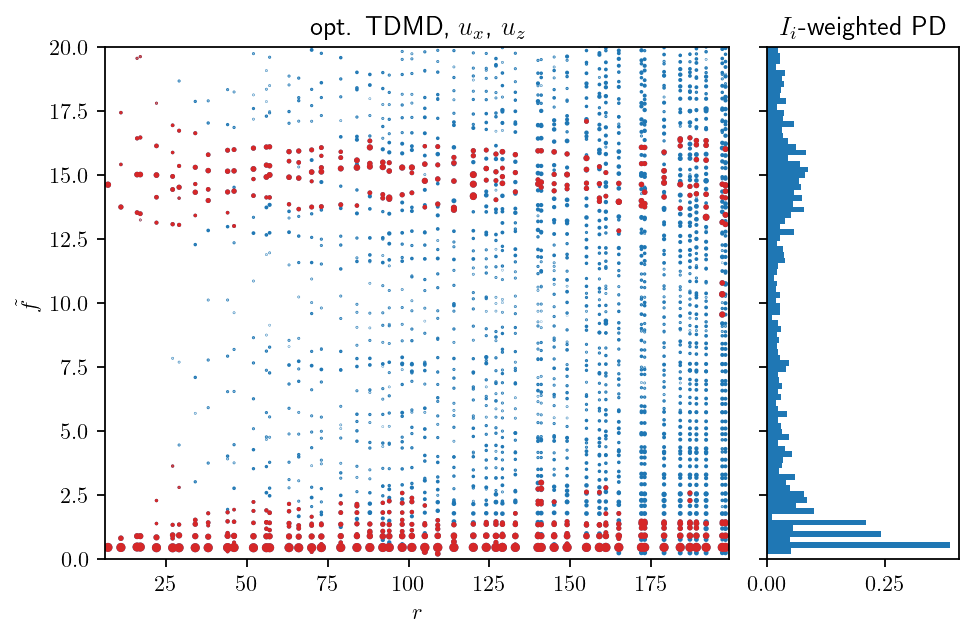

In [73]:
key = "optTDMD_vel_xz"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. TDMD, $u_x$, $u_z$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

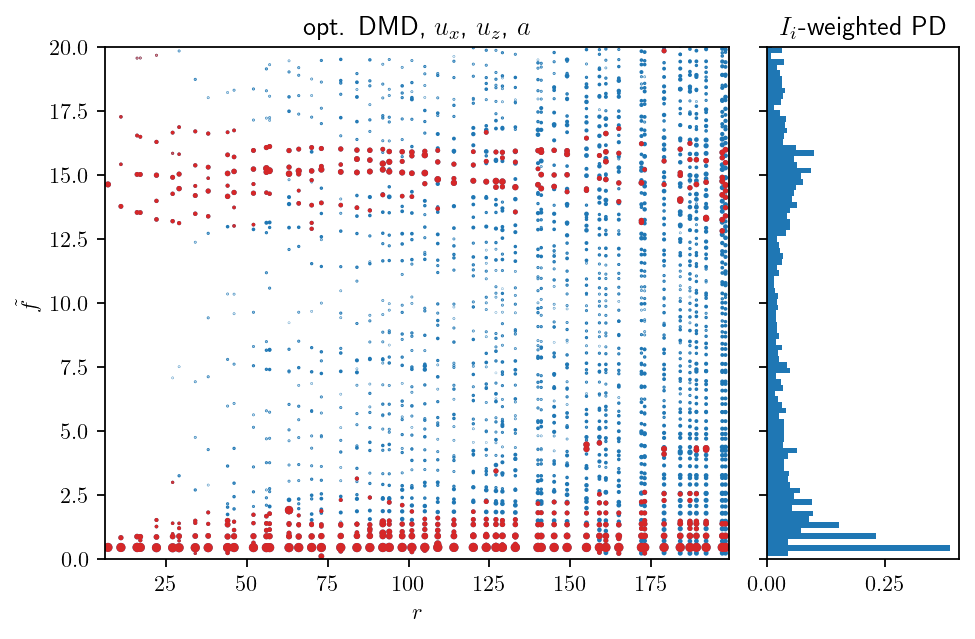

In [71]:
key = "optDMD_vel_axz"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. DMD, $u_x$, $u_z$, $a$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

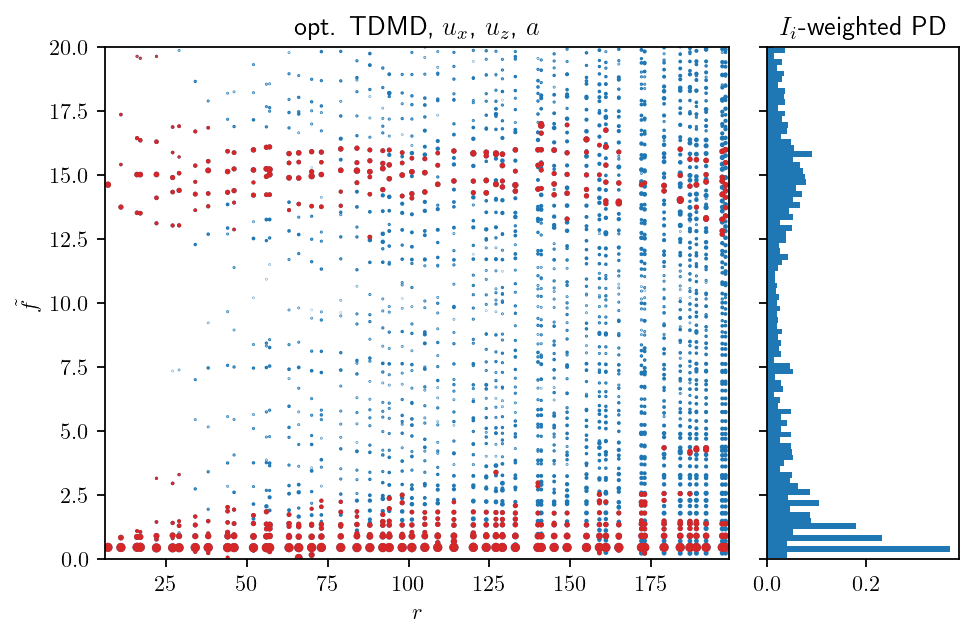

In [72]:
key = "optTDMD_vel_axz"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. TDMD, $u_x$, $u_z$, $a$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

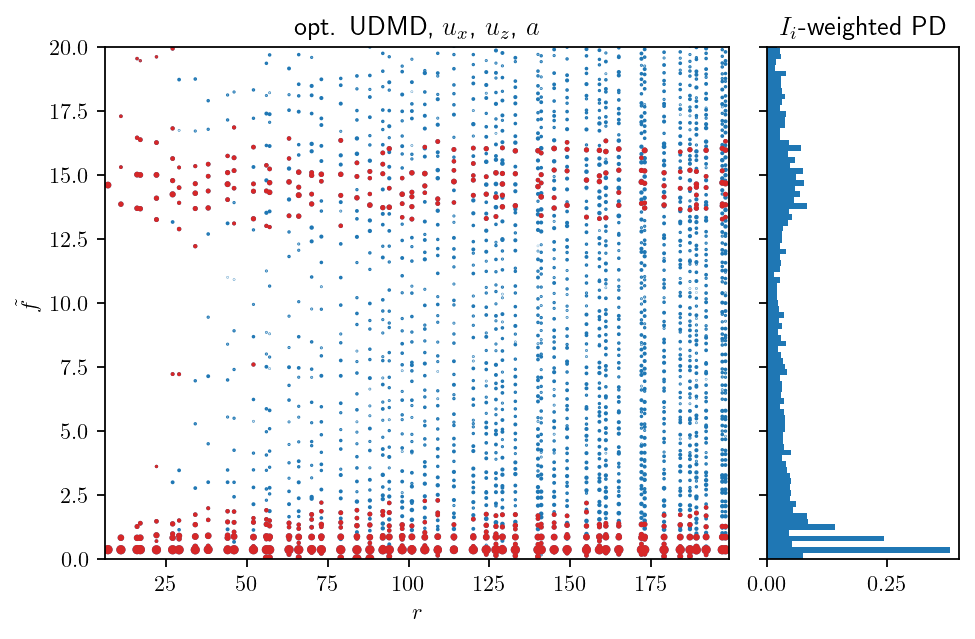

In [77]:
key = "optUDMD_vel_axz"
plot_spectra_over_rank(key, True, ranks, 10, 100, r"opt. UDMD, $u_x$, $u_z$, $a$")
plt.savefig(join(path, f"{key}_spectra_weighted.png"), bbox_inches="tight")
plt.show()

## Number of snapshots

In [60]:
dmd_variants = ("optDMD", "optTDMD", "optUDMD")
state_variants = ("cp", "rho", "uxy", "uxya")
all_variants = [f"{i[1]}_{i[0]}" for i in product(state_variants, dmd_variants)]
results = {}
for var in all_variants:
    with open(f"{path}{var}_snapshots.pkl", "rb") as source:
        results[var] = pickle.load(source)

In [61]:
TOL = 1.0
every = (1, 2, 4, 8, 16, 32, 64)
n_cycles = 5
n_snap = [len(times[::e]) for e in every]
n_snap_cycle = [int(n_s / n_cycles) for n_s in n_snap]
dt = times[1] - times[0]
f_max = normalize_frequency(pt.tensor([1.0 / (2.0*e*dt) for e in every]))

def extract_top_k_freq(key, k):
    f_i = []
    _, f, si = results[key][:3]
    for i in range(len(every)):
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        f_i.append(f[i][top_i[:k]])
    return f_i

In [62]:
f_max

tensor([73.9855, 36.9927, 18.4964,  9.2482,  4.6241,  2.3120,  1.1560])

In [63]:
def plot_topk_frequencies(data_key, k, title):
    markers = ("o", "x", "+")
    fb = 0.65173183
    for i, dmd_i in enumerate(("DMD", "TDMD", "UDMD")):
        label_set = False
        f = extract_top_k_freq(f"opt{dmd_i}_{data_key}", k)
        for n_s, f_j in zip(n_snap_cycle, f):
            n_f = f_j.shape[0]
            if not label_set:
                plt.scatter(pt.ones(n_f) * n_s, normalize_frequency(f_j), lw=1, marker=markers[i], c=f"C{i}", s=20, label=dmd_i)
                label_set = True
            else:
                plt.scatter(pt.ones(n_f) * n_s, normalize_frequency(f_j), lw=1, marker=markers[i], c=f"C{i}", s=20)
    plt.plot(n_snap_cycle, f_max, ls="--", c="k", label=r"$\tilde{f}_{\mathrm{Nyquist}}$")
    plt.axhline(fb, ls=":", c="k", label=r"$\tilde{f}_b$")
    plt.xlabel(r"$\tilde{f}_s/\tilde{f}_{b}$")
    plt.ylabel(r"$\tilde{f}$")
    plt.legend()
    plt.ylim(0.1, f_max[0])
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.savefig(f"{path}{data_key}_topk_frequency.pdf", bbox_inches="tight")
    plt.show()

In [64]:
n_show = 10

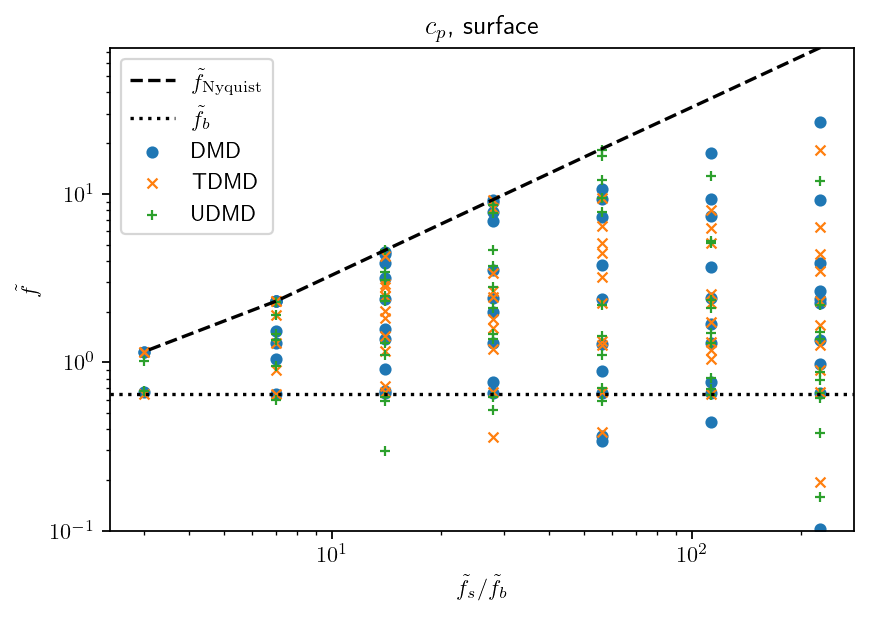

In [65]:
plot_topk_frequencies("cp", n_show, r"$c_p$, surface")

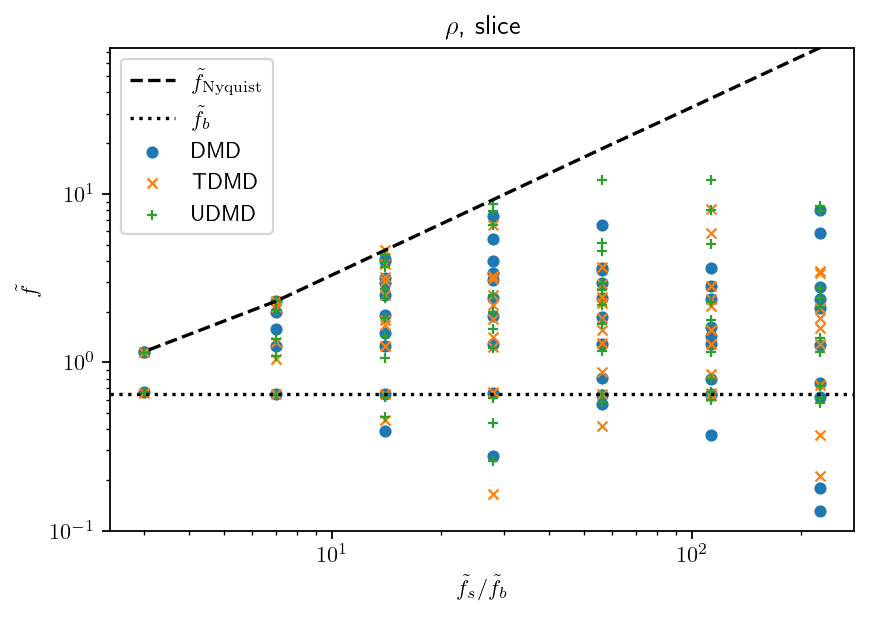

In [66]:
plot_topk_frequencies("rho", n_show, r"$\rho$, slice")

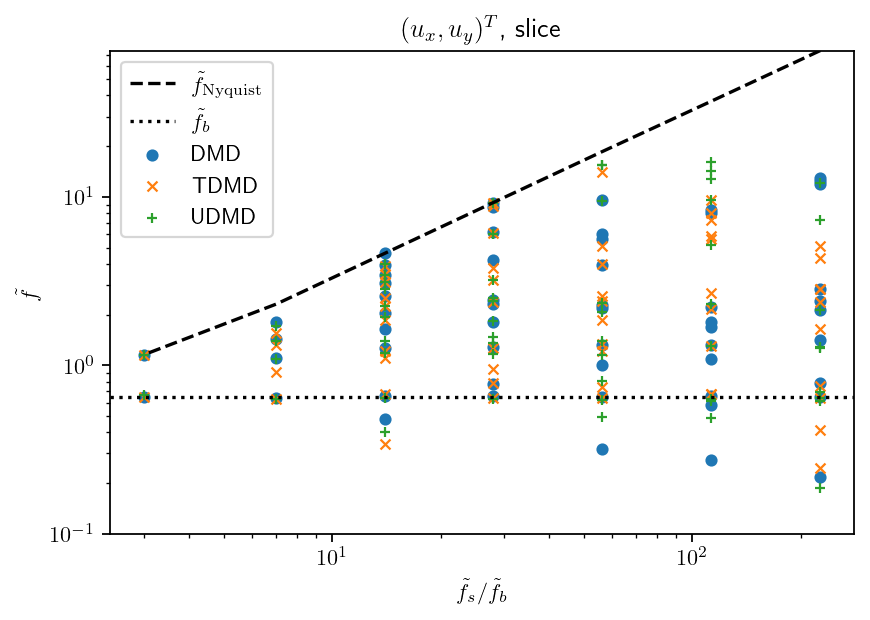

In [69]:
plot_topk_frequencies("uxy", n_show, r"$(u_x, u_y)^T$, slice")

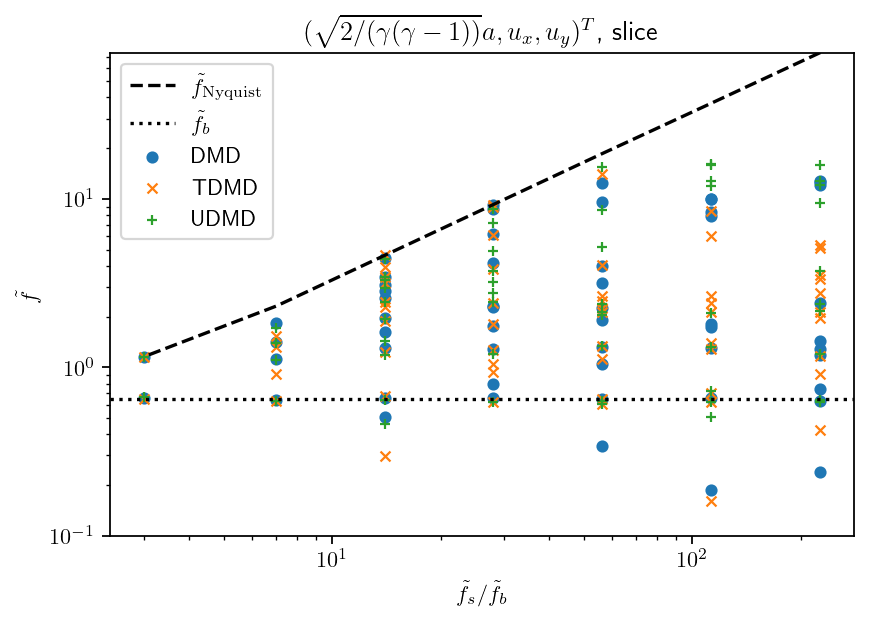

In [70]:
plot_topk_frequencies("uxya", n_show, r"$(\sqrt{2/(\gamma (\gamma -1))} a, u_x, u_y)^T$, slice")